<a href="https://colab.research.google.com/github/cornellradiology/SIIM19_EDA/blob/master/medium_pneumonia_eda_with_interactive_Q_and_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIIM - Data Science - Tier 1

We will investigate using pandas for exploratory data analysis as a pre-cursor to a machine learning models.  We'll be investigating the [RSNA pneumonia dataset used in the recently kaggle competition](https://kaggle.com/c/rsna-pneumonia-detection-challenge), where the purpose was to look at Chest X-rays and use machine learning to set bounding boxes for Lung Opacity (e.g., pneumonia).

#Preliminaries

## Create directory structure

Must import `os` package to change a directory correctly in python.

Define `ROOT_PATH` on google colab with `pneumonia` subdirectory and then change directory into that path.

In colab, you run bash linux commands by prefixing a command with an ! exclamation point, which we use to create the pneumonia subdirectory.  

Within a bash command run from a notebook, you can substitute in the value of python variables using the curly brace syntax `{variable_name}` will substitute to the current contents of the variable into the command.


In [0]:
import os
ROOT_PATH = '/content/pneumonia' # on colab you start in the path /content/
!mkdir -p {ROOT_PATH}
os.chdir(ROOT_PATH)
print(ROOT_PATH)

## Download the Data

In colab, you run bash linux commands by prefixing a command with an ! exclamation point.  The first command below uses `wget` to download a file from a given URL; in this case a compressed zip file from the URL to your colab instance.  

Within bash commands run in ipython notebooks you can substitute python variables with the curly brace syntax `{variable_name}` which will substitute with the value of `variable_name`.


In [0]:
#DOWNLOAD_URL = 'http://quarkonia.info/media/small_rsna_pneumonia.zip' # 12MB zip file - 60 train images; 20 test images

DOWNLOAD_URL = 'http://quarkonia.info/media/medium_rsna_pneumonia.zip' # 53MB zip file - 300 train images; 100 test images

ZIP_FILE = DOWNLOAD_URL.split('/')[-1] # split string at '/' and take last part which is file name

if not os.path.exists(ZIP_FILE): # Download if it doesn't exist
  !wget --show-progress {DOWNLOAD_URL}
else:
  print("Zip file already exists")

print("Current path:")
!pwd
print("\nCurrent directory contents:")
!ls


## OPTIONAL Use Full Data Set


The full RSNA dataset from the kaggle challenge is available at:

https://www.kaggle.com/c/rsna-pneumonia-detection-challenge

(but requires creating an account and signing up with kaggle as well as downloading 3.7 GB of compressed data instead of the smaller 52 MB sample with 300 training images).

After registering and downloading from kaggle, you can then upload to google drive by changing `use_full` from False to True with the code below.  However it will take a significant time to download and upload.

In [0]:
use_full = False

if use_full:
  from google.colab import files
  files.upload()
  ZIP_FILE = 'rsna-pneumonia-detection-challenge.zip'

##Unzip into expected directory structure

This takes the zip file you've downloaded, fix permissions (initially restrictive on the full RSNA dataset) and extracts the training images into a directory called `pneumonia/train`

In [0]:
if not os.path.exists('train/'):
  !unzip {ZIP_FILE}
  !chmod 664 *.zip *.csv
  os.mkdir('train/')
  !unzip -q stage_2_train_images.zip -d train/
else:
  print("Already unzipped.")

# Basic import statements to load common libraries

* `os` is a built-in python library for exploring the file system.
* [pandas](https://pandas.pydata.org/) is a library for reading and processing tabular data.
* [numpy](https://www.numpy.org/) is a library for fast numerical operations on arrays of numerical data
* [matplotlib](https://matplotlib.org/) is a plotting library
* [pydicom](https://pydicom.github.io/pydicom/stable/getting_started.html) is a library for opening and loading dicom images
* [seaborn](https://seaborn.pydata.org/) is a plotting library built on top of matplotlib with a higher level interface with better defaults for data visualization ([seaborn tutorial](https://www.datacamp.com/community/tutorials/seaborn-python-tutorial))

## Install libraries not installed by default in Google Colab

The packages pandas, numpy, matplotlib are by default installed on google colab, however pydicom is not automatically included so we have to go to the command line and install using `pip` (the python package installer).  We first try to import the module (if it exists), but if it doesn't exist we catch the `ImportError`, use pip to install the package on colab and then import it.

In [0]:
try:
  import pydicom as dcm
except ImportError:
  !pip install pydicom
  import pydicom as dcm

To import a module into python, it is simply `import module` and you can access functions (or submodules, classes, variables, etc.) belonging to the module via `module.name_of_thing_in_module`.  For importing `pandas`, `numpy`, `matplotlib.pyplot` it is convenient to import using common abbreviations.

In [0]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') # done to silence a seaborn deprecation warning


# Explore the Spreadsheet Data

## Open the data into panda dataframes

There are two CSVs associated with RSNA pneumonia challenge that we will load into pandas dataframes.

A pandas **dataframe** is a collection of tabular data, similar to a spreadsheet, and is the primary data structure for pandas.

Since we have the tabular data loaded into CSV spreadsheet, we will use `pd.read_csv(file_name)` to read into file name.

In [0]:
bbox_df = pd.read_csv('stage_2_train_labels.csv')         # CSV of labeled bounding box information
class_df = pd.read_csv('stage_2_detailed_class_info.csv') # CSV with extra detailed_class_info

### Jupyter Notebook Tip #1: How to find documentation

If you need to get documentation in google colab for a function when you forgot the syntax or options, either:

1. execute a cell where the function ends with a question mark (`pd.read_csv?`)
2. type the name of the function with an open paranthesis `pd.read_csv(` and press tab to have documentation pop-up in a hover window.


---


In a Jupyter notebook (similar to colab but run locally) you can press shift-tab to pop up the same information.

Similarly you colab and Jupyter notebooks have tab auto_complete.  (E.g., press tab after typing in `pd.` to see things in pandas namespace or tab after `pd.rea` to see a list of options)

### Jupyter Notebook Tip #2: Jupyter pretty-prints last value returned in codeblock

You can insert multiple lines of python code inside a Jupyter codeblock.

If the last python line in a code block returns a value, it will be displayed (and formatted nicely by default in a better format than a regular `print()` statement)  below the codeblock.  When you assign a value to a variable, python will NOT return a value. 

Thus a common pattern in codeblocks is to say calculate a dataframe, assign it to something, and then repeat the last calculated value to display it.

In [0]:
df = bbox_df.copy() # create a copy of bbox_df
df

## View Samples of CSV Data in DataFrame

`df.head()` is a useful function to look at the first n=5 rows of a dataframe to get a feel for the dataframe.

`df.tail()` acts similarly looking at the last n=5 rows of the dataframe

`df.sample()` looks at n=5 randomly selected entries

### Data field descriptions from [RSNA pneumonia dataset](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data):

* `patientId`- A patientId. Each patientId corresponds to a unique image.
* `x` - the upper-left x coordinate of the bounding box.
* `y` - the upper-left y coordinate of the bounding box.
* `width` - the width of the bounding box.
* `height` - the height of the bounding box.
* `Target` - the binary Target, indicating whether this sample has evidence of pneumonia.


###Q1 - Q3


In [0]:
# Q1: View first 5 rows of bounding box training label data frame.

In [0]:
# Q2: View last 10 rows of detailed class label data frame

In [0]:
# Q3: Sample 20 random entries of bounding box training label data frame

####Q1 - Q3 solutions



In [0]:
bbox_df.head() # Note it defaults to N=5

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity

[5 rows x 8 columns]

In [0]:
class_df.tail(10)

patientId                         class
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f  No Lung Opacity / Not Normal
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da                        Normal
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2                  Lung Opacity
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2                  Lung Opacity
30221  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8                  Lung Opacity
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba                        Normal
30224  c1f6b555-2eb1-4231-98f6-50a963976431                        Normal
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a                  Lung Opacity

In [0]:
bbox_df.sample(20)

patientId  ...                         class
27307  f295132a-40a6-4e4d-94fb-a5b05f8915d5  ...                        Normal
21009  bec82e55-c1d8-4f3c-afd0-19f76b08c96d  ...                        Normal
13553  8810a730-3f76-408d-ac9d-cef6e9629c89  ...                  Lung Opacity
2606   32e6fd38-0e31-450c-93ec-f29ea5a6ad2c  ...                  Lung Opacity
6874   5258e07a-292d-495a-8c66-8cbc9221ec14  ...  No Lung Opacity / Not Normal
27755  f650ee02-3a03-4da0-8fd9-12f1ffae35b4  ...                  Lung Opacity
13533  87e6c696-1388-4d69-aad2-e8c28d5b4f38  ...  No Lung Opacity / Not Normal
20400  badbcf00-4431-4336-ba44-c519688be0e4  ...                  Lung Opacity
460    07c99b1f-cf0c-40da-8ea9-8c5c9cd51189  ...                  Lung Opacity
2304   308eab64-517b-46f1-8865-d9566b087bff  ...                  Lung Opacity
22326  c9ef5f00-e918-46d6-897f-ee78fc1310d5  ...                  Lung Opacity
4459   3f167edb-74e4-4a4a-b710-9732659ac767  ...                  Lung Opacity
17011  a38da508-e84e-4ba5-9977-1558133d8ea8  ...                        Normal
4850   41c5ca32-16da-4e95-8e33-7d9c74310169  ...  No Lung Opacity / Not Normal
8769   62427674-f93d-4db2-b8a3-b86ebd1c63f9  ...  No Lung Opacity / Not Normal
20246  ba07114f-788c-4779-98cd-1190bfb6bdc2  ...                  Lung Opacity
3650   39c1395d-f5d7-4ce2-9154-04bd38bc8729  ...                  Lung Opacity
3946   3bba8ae0-61b8-4682-8b16-2e08078878b9  ...                  Lung Opacity
24236  d9b9ecb8-e27f-4f0b-8a22-822243272131  ...  No Lung Opacity / Not Normal
29372  134bc526-8ebb-4419-9274-e2249fb3623f  ...  No Lung Opacity / Not Normal

[20 rows x 8 columns]

## Describe the Dataset

`df.shape` returns the shape of the dataframe.  Note this is a property of the dataframe, not a function (hence no parentheses)
`df.describe()` shows summary statistics about a dataframe. 

For object (categorical/string/timestamp) data, it shows:

* the **count** of each column, 
* the number of **unique** entries, 
* the **top** (most frequent) entry
* the **freq**uency of the top entry (number of occurrences)

For numerical data, it shows the **count**, **mean** (average), **std** (standard deviation), **min**imum, **25%** percentile, **50%** percentile (median), **75%** percentile, and **max**imum.

If both categorical data and numerical data columns are present, by default `df.describe()` will only describe the numerical columns.  However, you can show both with `df.describe(include='all')`.

### Q4 - Q5

In [0]:
# Q4: What are the dimensions of bbox_df and class_df?

In [0]:
# Q5: What is the most frequent category of descriptive class label and for how many bounding boxes does this label occur?

#### Q4 - Q5 solutions

In [0]:
print("BBox Shape:", bbox_df.shape)
print("Class info Shape:", class_df.shape)

BBox Shape: (30227, 8)
Class info Shape: (30227, 2)


In [0]:
class_df.describe(include='all')

patientId                         class
count                                  30227                         30227
unique                                 26684                             3
top     3239951b-6211-4290-b237-3d9ad17176db  No Lung Opacity / Not Normal
freq                                       4                         11821

## Pandas Slicing

First you can select a column from a dataframe in pandas by either the syntax:

`df['column_name']` or `df.column_name`

which returns a pandas Series (an array of data) containing that column of data.  The first method will always work regardless of column name, but the second is a convenience method that can be used when there are no spaces or other special characters in the column name and the name doesn't otherwise clash (e.g., isn't a member function of a pandas dataFrame).

You can then compare this array element by element with standard comparison operators; e.g., the following will find be set to True when the row has a Target of 0 and False otherwise.


In [0]:
bbox_df.Target == 0 # Returns pandas.Series filled with True when the row has a Target of 0, False otherwise.

0         True
1         True
2         True
3         True
4        False
5        False
6         True
7         True
8        False
9        False
10        True
11        True
12        True
13        True
14       False
15       False
16       False
17       False
18        True
19       False
20       False
21        True
22       False
23        True
24       False
25       False
26        True
27       False
28       False
29        True
         ...  
30197    False
30198    False
30199    False
30200    False
30201    False
30202    False
30203    False
30204     True
30205    False
30206     True
30207     True
30208    False
30209    False
30210     True
30211     True
30212     True
30213     True
30214    False
30215    False
30216     True
30217     True
30218     True
30219    False
30220    False
30221    False
30222    False
30223     True
30224     True
30225    False
30226    False
Name: Target, Length: 30227, dtype: bool

####Q6

In [0]:
# Q6: demonstrate that the first column patientId is the same in class_df and bbox_df


##### Q6 Hint (python's `any` and `all` built-**ins**)

In [0]:
# Python comes with built-in operators that allow you to test whether `any` or `all` elements in a collection evaluate when converted to booleans are True or False 

any([False, True, False]) # returns True - one value is True
all([False, True, True])  # returns False - all aren't True

# Note python's any and all functions will attempt to cast values to booleans before testing them.
# In python things types that translate to being empty or zero translate to being Falsy (e.g., "", 0, None, [], {}, etc.) and otherwise evaluate to being True.

any([False, "", 0, None, [], {}]) # returns False - False, "", 0, None, [], {} are all considered Falsy types in python.
all([True, "Hello", 1]) # returns True; in python non-empty strings, non-zero numbers when cast to bool evaluate to True

##### Q6 Answer

In [0]:
all(bbox_df['patientId'] == class_df['patientId']) # demonstrating the patientId column is the same in both df when compared row by row.

True

## Boolean Array Indexing

You can then use this True/False pandas.Series to index your dataframe and only select rows where the entry in the Series is True.

`df[df.Target == 0]` # picks out rows from `df` where the value of `Target` column is `0`.

We can then verify the non-null count using the function `df.count()` which returns the number of rows where each column is non-null.

Note this type of slicing (Boolean Array Indexing) is not only used for selecting slices of a dataframe, but can also be used for updating slices of a data frame.



In [0]:
bbox_df[bbox_df.Target == 0] # This selects all rows of bbox_df with Target==0

patientId  ...                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
6      00569f44-917d-4c86-a842-81832af98c30  ...  No Lung Opacity / Not Normal
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...  No Lung Opacity / Not Normal
10     008c19e8-a820-403a-930a-bc74a4053664  ...  No Lung Opacity / Not Normal
11     009482dc-3db5-48d4-8580-5c89c4f01334  ...                        Normal
12     009eb222-eabc-4150-8121-d5a6d06b8ebf  ...                        Normal
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a  ...                        Normal
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b  ...  No Lung Opacity / Not Normal
21     00f87de5-5fe0-4921-93ea-914d7e683266  ...                        Normal
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34  ...                        Normal
26     011d6f51-b732-4d45-a84d-90477325ef2d  ...  No Lung Opacity / Not Normal
29     014b7b58-f641-4477-8bbc-ae6f337745d6  ...  No Lung Opacity / Not Normal
30     01538c3b-3de9-4fbb-95a8-732235821bbf  ...  No Lung Opacity / Not Normal
31     016b1f90-bb9a-4d3a-9c38-74af5fffd5b5  ...  No Lung Opacity / Not Normal
34     017c7b5b-618e-4bc9-943c-04c6a988d992  ...                        Normal
35     019ca122-9cdf-4704-b7a9-449c8a1c263e  ...                        Normal
38     019e035e-2f82-4c66-a198-57422a27925f  ...  No Lung Opacity / Not Normal
39     01a4059c-22f7-4f51-8a27-50aff0b3aeb3  ...                        Normal
40     01a5594f-e5d4-4f7a-b79d-3f57559fe37b  ...  No Lung Opacity / Not Normal
45     01aad2a6-3b93-45e3-bf37-2d73348cb6fc  ...                        Normal
47     01b15f07-1149-4ff8-9756-bc821e41b97c  ...                        Normal
48     01b56434-4dd9-4994-bcc5-0b70a36e415a  ...  No Lung Opacity / Not Normal
53     01be3fe5-4a91-4c57-9af6-305966a7d0aa  ...                        Normal
54     01c09fb1-a917-46ee-8d94-44f844a4eb85  ...  No Lung Opacity / Not Normal
55     01c0b605-0a82-401b-9649-81252304ac45  ...                        Normal
56     01c7cc7c-7004-441f-9049-77b7b444dd6b  ...  No Lung Opacity / Not Normal
59     01cc7c75-4498-43ab-b650-5553d0507f76  ...                        Normal
...                                     ...  ...                           ...
30156  c003fdb7-d3ca-4295-92a8-03b32bffc780  ...  No Lung Opacity / Not Normal
30157  c0052da2-7dcd-47e9-9300-122801e1617b  ...                        Normal
30163  c05d1108-641a-465c-9b56-b32bcb548bb3  ...  No Lung Opacity / Not Normal
30170  c0760d93-760c-4be7-afca-5e9914e6f8f1  ...                        Normal
30173  c0801452-425d-4196-b369-8abd70fa3268  ...  No Lung Opacity / Not Normal
30177  c0a4c55a-bd1b-4459-ba2a-8a687c2732e9  ...  No Lung Opacity / Not Normal
30178  c0d8eb9f-8276-414b-8cbb-d8f28b61aac1  ...  No Lung Opacity / Not Normal
30179  c0dd2290-7dc1-4589-8061-57dfdfa23a4c  ...  No Lung Opacity / Not Normal
30180  c0dec778-b56c-4c6e-8132-a606e845235c  ...  No Lung Opacity / Not Normal
30181  c0efaacc-6601-4193-9858-f5da77a86ee3  ...                        Normal
30182  c0f3d102-ed5f-4820-81d4-89cefcf2d53a  ...                        Normal
30185  c104d585-85a7-4071-b7ff-930ac2565128  ...                        Normal
30186  c1051685-99dc-41aa-be48-a3d120194035  ...  No Lung Opacity / Not Normal
30189  c10726b6-c944-403f-9062-f0bf922ef149  ...  No Lung Opacity / Not Normal
30192  c1098ce4-cb15-41c6-ba39-1fa511b82100  ...                        Normal
30193  c10ae3e5-822f-49e9-8c02-b0e2a98eddc1  ...  No Lung Opacity / Not Normal
30194  c110e1ed-fb28-4b3d-b450-e370f13d4293  ...                        Normal
30195  c1265ac3-6eae-4cf3-9880-26fd430312f3  ...  No Lung Opacity / Not Normal
30204  c1592aae-c80d-4794-ab28-463905558534  ...                        Normal
30206

In [0]:
bbox_df[bbox_df.Target == 0].count()

patientId    20672
x                0
y                0
width            0
height           0
Target       20672
area             0
class        20672
dtype: int64

## Adding a Column to DataFrame

The syntax for adding a column to a dataframe is simple; you just create a new column name and assign to it with a Series of the correct size.  

For example if I wanted to add a column to our data frame called Area being a product of `bbox_df.width` x `bbox_df.height`

In [0]:
bbox_df['area'] = bbox_df.width * bbox_df.height
bbox_df

patientId  ...                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
5      00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
6      00569f44-917d-4c86-a842-81832af98c30  ...  No Lung Opacity / Not Normal
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...  No Lung Opacity / Not Normal
8      00704310-78a8-4b38-8475-49f4573b2dbb  ...                  Lung Opacity
9      00704310-78a8-4b38-8475-49f4573b2dbb  ...                  Lung Opacity
10     008c19e8-a820-403a-930a-bc74a4053664  ...  No Lung Opacity / Not Normal
11     009482dc-3db5-48d4-8580-5c89c4f01334  ...                        Normal
12     009eb222-eabc-4150-8121-d5a6d06b8ebf  ...                        Normal
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a  ...                        Normal
14     00aecb01-a116-45a2-956c-08d2fa55433f  ...                  Lung Opacity
15     00aecb01-a116-45a2-956c-08d2fa55433f  ...                  Lung Opacity
16     00c0b293-48e7-4e16-ac76-9269ba535a62  ...                  Lung Opacity
17     00c0b293-48e7-4e16-ac76-9269ba535a62  ...                  Lung Opacity
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b  ...  No Lung Opacity / Not Normal
19     00f08de1-517e-4652-a04f-d1dc9ee48593  ...                  Lung Opacity
20     00f08de1-517e-4652-a04f-d1dc9ee48593  ...                  Lung Opacity
21     00f87de5-5fe0-4921-93ea-914d7e683266  ...                        Normal
22     0100515c-5204-4f31-98e0-f35e4b00004a  ...                  Lung Opacity
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34  ...                        Normal
24     010ccb9f-6d46-4380-af11-84f87397a1b8  ...                  Lung Opacity
25     010ccb9f-6d46-4380-af11-84f87397a1b8  ...                  Lung Opacity
26     011d6f51-b732-4d45-a84d-90477325ef2d  ...  No Lung Opacity / Not Normal
27     012a5620-d082-4bb8-9b3b-e72d8938000c  ...                  Lung Opacity
28     012a5620-d082-4bb8-9b3b-e72d8938000c  ...                  Lung Opacity
29     014b7b58-f641-4477-8bbc-ae6f337745d6  ...  No Lung Opacity / Not Normal
...                                     ...  ...                           ...
30197  c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0  ...                  Lung Opacity
30198  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  ...                  Lung Opacity
30199  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  ...                  Lung Opacity
30200  c145df8e-9631-468d-af7f-5690c11c2c88  ...                  Lung Opacity
30201  c145df8e-9631-468d-af7f-5690c11c2c88  ...                  Lung Opacity
30202  c14d9ceb-019f-45f6-9299-281b58de57df  ...                  Lung Opacity
30203  c14d9ceb-019f-45f6-9299-281b58de57df  ...                  Lung Opacity
30204  c1592aae-c80d-4794-ab28-463905558534  ...                        Normal
30205  c1628c47-5ba3-42dd-8df3-7ad3abd57ad0  ...                  Lung Opacity
30206  c164b17b-aff8-484f-9d9e-dde2932d8df9  ...  No Lung Opacity / Not Normal
30207  c1718678-44af-407f-829a-fc65bc854094  ...  No Lung Opacity / Not Normal
30208  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  ...                  Lung Opacity
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  ...                  Lung Opacity
30210  c196ce23-f37c-4ab3-a9ce-ea8ede90e09c  ...                        Normal
30211  c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7  ...                        Normal
30212  c1c3ec5d-20ba-42f7-91f9-48032d97ffc9  ...                        Normal
30213  c1ca4417-83a6-43a7-a9bf-7d9587e7f14f  ...                        Normal
30214  c1cddf32-b957-4753-acaa-472ab1447e86  ...                  Lung Opacity
30215  c1cddf32-b957-4753-acaa-472ab1447e86  ...                  Lung Opacity
30216

##Merge DataFrames

It makes sense to merge dataframes.  Now in Q6 we showed the patientId column is identically sized and there's a one-to-one correspondance between rows, there are two valid ways to merge the dataframes in this case.

We could simply copy a new column in our DataFrame by copying the class column off of `class_df`:


In [0]:
bbox_df['class'] = class_df['class']
bbox_df

patientId  ...                         class
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2      00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4      00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
5      00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
6      00569f44-917d-4c86-a842-81832af98c30  ...  No Lung Opacity / Not Normal
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...  No Lung Opacity / Not Normal
8      00704310-78a8-4b38-8475-49f4573b2dbb  ...                  Lung Opacity
9      00704310-78a8-4b38-8475-49f4573b2dbb  ...                  Lung Opacity
10     008c19e8-a820-403a-930a-bc74a4053664  ...  No Lung Opacity / Not Normal
11     009482dc-3db5-48d4-8580-5c89c4f01334  ...                        Normal
12     009eb222-eabc-4150-8121-d5a6d06b8ebf  ...                        Normal
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a  ...                        Normal
14     00aecb01-a116-45a2-956c-08d2fa55433f  ...                  Lung Opacity
15     00aecb01-a116-45a2-956c-08d2fa55433f  ...                  Lung Opacity
16     00c0b293-48e7-4e16-ac76-9269ba535a62  ...                  Lung Opacity
17     00c0b293-48e7-4e16-ac76-9269ba535a62  ...                  Lung Opacity
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b  ...  No Lung Opacity / Not Normal
19     00f08de1-517e-4652-a04f-d1dc9ee48593  ...                  Lung Opacity
20     00f08de1-517e-4652-a04f-d1dc9ee48593  ...                  Lung Opacity
21     00f87de5-5fe0-4921-93ea-914d7e683266  ...                        Normal
22     0100515c-5204-4f31-98e0-f35e4b00004a  ...                  Lung Opacity
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34  ...                        Normal
24     010ccb9f-6d46-4380-af11-84f87397a1b8  ...                  Lung Opacity
25     010ccb9f-6d46-4380-af11-84f87397a1b8  ...                  Lung Opacity
26     011d6f51-b732-4d45-a84d-90477325ef2d  ...  No Lung Opacity / Not Normal
27     012a5620-d082-4bb8-9b3b-e72d8938000c  ...                  Lung Opacity
28     012a5620-d082-4bb8-9b3b-e72d8938000c  ...                  Lung Opacity
29     014b7b58-f641-4477-8bbc-ae6f337745d6  ...  No Lung Opacity / Not Normal
...                                     ...  ...                           ...
30197  c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0  ...                  Lung Opacity
30198  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  ...                  Lung Opacity
30199  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  ...                  Lung Opacity
30200  c145df8e-9631-468d-af7f-5690c11c2c88  ...                  Lung Opacity
30201  c145df8e-9631-468d-af7f-5690c11c2c88  ...                  Lung Opacity
30202  c14d9ceb-019f-45f6-9299-281b58de57df  ...                  Lung Opacity
30203  c14d9ceb-019f-45f6-9299-281b58de57df  ...                  Lung Opacity
30204  c1592aae-c80d-4794-ab28-463905558534  ...                        Normal
30205  c1628c47-5ba3-42dd-8df3-7ad3abd57ad0  ...                  Lung Opacity
30206  c164b17b-aff8-484f-9d9e-dde2932d8df9  ...  No Lung Opacity / Not Normal
30207  c1718678-44af-407f-829a-fc65bc854094  ...  No Lung Opacity / Not Normal
30208  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  ...                  Lung Opacity
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  ...                  Lung Opacity
30210  c196ce23-f37c-4ab3-a9ce-ea8ede90e09c  ...                        Normal
30211  c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7  ...                        Normal
30212  c1c3ec5d-20ba-42f7-91f9-48032d97ffc9  ...                        Normal
30213  c1ca4417-83a6-43a7-a9bf-7d9587e7f14f  ...                        Normal
30214  c1cddf32-b957-4753-acaa-472ab1447e86  ...                  Lung Opacity
30215  c1cddf32-b957-4753-acaa-472ab1447e86  ...                  Lung Opacity
30216

In [0]:
# But we are going to do it a different way, so let's delete that column
del bbox_df['class']
bbox_df

patientId      x  ...  Target      area
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...       0       NaN
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...       0       NaN
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...       0       NaN
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...       0       NaN
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  ...       1   80727.0
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  ...       1  115968.0
6      00569f44-917d-4c86-a842-81832af98c30    NaN  ...       0       NaN
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN  ...       0       NaN
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  ...       1   16640.0
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  ...       1   22194.0
10     008c19e8-a820-403a-930a-bc74a4053664    NaN  ...       0       NaN
11     009482dc-3db5-48d4-8580-5c89c4f01334    NaN  ...       0       NaN
12     009eb222-eabc-4150-8121-d5a6d06b8ebf    NaN  ...       0       NaN
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN  ...       0       NaN
14     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  ...       1   12690.0
15     00aecb01-a116-45a2-956c-08d2fa55433f  547.0  ...       1   19635.0
16     00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  ...       1   40992.0
17     00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  ...       1   58504.0
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b    NaN  ...       0       NaN
19     00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  ...       1  104236.0
20     00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  ...       1  109480.0
21     00f87de5-5fe0-4921-93ea-914d7e683266    NaN  ...       0       NaN
22     0100515c-5204-4f31-98e0-f35e4b00004a  703.0  ...       1    6468.0
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34    NaN  ...       0       NaN
24     010ccb9f-6d46-4380-af11-84f87397a1b8  652.0  ...       1   47173.0
25     010ccb9f-6d46-4380-af11-84f87397a1b8  301.0  ...       1   39339.0
26     011d6f51-b732-4d45-a84d-90477325ef2d    NaN  ...       0       NaN
27     012a5620-d082-4bb8-9b3b-e72d8938000c  133.0  ...       1   75625.0
28     012a5620-d082-4bb8-9b3b-e72d8938000c  678.0  ...       1   76160.0
29     014b7b58-f641-4477-8bbc-ae6f337745d6    NaN  ...       0       NaN
...                                     ...    ...  ...     ...       ...
30197  c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0  606.0  ...       1   79488.0
30198  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  131.0  ...       1   81106.0
30199  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  497.0  ...       1   90896.0
30200  c145df8e-9631-468d-af7f-5690c11c2c88  601.0  ...       1   66259.0
30201  c145df8e-9631-468d-af7f-5690c11c2c88  173.0  ...       1   46280.0
30202  c14d9ceb-019f-45f6-9299-281b58de57df  578.0  ...       1   40506.0
30203  c14d9ceb-019f-45f6-9299-281b58de57df  239.0  ...       1   71896.0
30204  c1592aae-c80d-4794-ab28-463905558534    NaN  ...       0       NaN
30205  c1628c47-5ba3-42dd-8df3-7ad3abd57ad0  622.0  ...       1   19072.0
30206  c164b17b-aff8-484f-9d9e-dde2932d8df9    NaN  ...       0       NaN
30207  c1718678-44af-407f-829a-fc65bc854094    NaN  ...       0       NaN
30208  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  646.0  ...       1   29046.0
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  295.0  ...       1   23408.0
30210  c196ce23-f37c-4ab3-a9ce-ea8ede90e09c    NaN  ...       0       NaN
30211  c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7    NaN  ...       0       NaN
30212  c1c3ec5d-20ba-42f7-91f9-48032d97ffc9    NaN  ...       0       NaN
30213  c1ca4417-83a6-43a7-a9bf-7d9587e7f14f    NaN  ...       0       NaN
30214  c1cddf32-b957-4753-acaa-472ab1447e86  269.0  ...       1   55005.0
30215  c1cddf32-b957-4753-acaa-472ab1447e86  766.0  ...       1   28755.0
30216  c1cf3255-d734-4980-bfe0-967902ad7ed9    NaN  ...       0       NaN
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f    NaN  ...       0       NaN
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da    NaN  ...       0       NaN
30219  c1e73a4e-7afe-4ec5-8af6-ce8315d

### Using merge to join DataFrame akin to SQL JOIN

We can take two distinct dataframes in pandas and merge them into one concatenated dataframe, similar to a [SQL JOIN](https://i.stack.imgur.com/VQ5XP.png).

In `left_df.merge(right_df, on='patientId', how='inner')`

the parameter `on` determines the column we merge on  and `how` specifies whether we do an

* `inner`:  inner join (use intersection of keys),  
* `left`:  outer join (always keep left key)
* `right`:  outer join (always keep right key)
* `outer`:  outer join (use union of two keys)

Note because `stage2_detailed_class_info.csv` has one row for every bounding box (with the same label for all bounding boxes corresponding to the same patient), we should first remove duplicate rows before doing a JOIN type merge with `df.drop_duplicates()`.  

If we do not remove duplicates before joining we'll find that doing a naive inner JOIN on patientId when there are four bounding boxes on a patient they'll be four rows in `bbox_df` and four rows in `class_df`  and after the merge we'll incorrectly have 16 combinations of rows where the patientId matched.

### Q7

In [0]:
# Create a dataframe with no repeated rows with the information in class_df to remove repeated rows
# Do a merge between bbox_df and class_df with no duplicates.  Call this merged dataframe `df`
# Inspect the merged dataframe


#### Q7 Solution

In [0]:
class_df_no_dups = class_df.drop_duplicates()
df = bbox_df.merge(class_df_no_dups, on='patientId', how='inner')
df.head(8)

patientId  ...                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  ...  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  ...  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  ...  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5  ...                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
5  00436515-870c-4b36-a041-de91049b9ab4  ...                  Lung Opacity
6  00569f44-917d-4c86-a842-81832af98c30  ...  No Lung Opacity / Not Normal
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970  ...  No Lung Opacity / Not Normal

[8 rows x 8 columns]

In [0]:
df.describe(include='all') # show numerical and string data

patientId  ...                         class
count                                  30227  ...                         30227
unique                                 26684  ...                             3
top     3239951b-6211-4290-b237-3d9ad17176db  ...  No Lung Opacity / Not Normal
freq                                       4  ...                         11821
mean                                     NaN  ...                           NaN
std                                      NaN  ...                           NaN
min                                      NaN  ...                           NaN
25%                                      NaN  ...                           NaN
50%                                      NaN  ...                           NaN
75%                                      NaN  ...                           NaN
max                                      NaN  ...                           NaN

[11 rows x 8 columns]

## View distribution of data with histograms

`df.hist()` specifies a histogram showing the distribution of values of each column of numerical data.  Note these plots are generated from pandas by internally calling matplotlib.


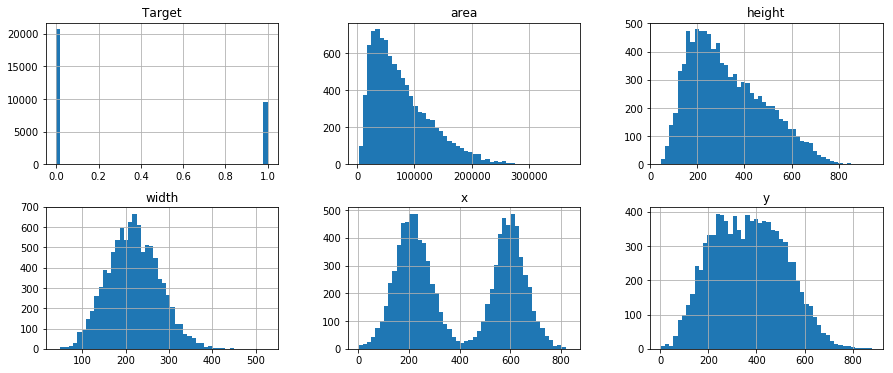

In [0]:
hist = df.hist(bins=50, layout=(2,3), figsize=(15,6))

## Inspect Missing Data

We've defined a function below to inspect the missing data.
 
 `df.isnull()` return `False` (0) if a cell is non-empty or `True` (1) when a cell is null (or `NaN`).
 
 `df.isnull().sum()` then counts the number of null rows in every column of `df` (note in python `True+True==2`)
 
 `df.index` returns the index of row labels that can quickly be counted to specify number of rows using `len(df.index)`
 
 `pd.concat` concatenates pandas Series (a column of pandas data) along an axis and appends appropriate labels.

In [0]:
def missing_data(df):
  null_data = df.isnull().sum()
  num_rows = len(df.index)
  percent_null = 100.*null_data/num_rows
  return pd.concat([null_data, percent_null.round(1)], axis=1, keys=['Missing', 'PercentMissing'])

missing_data(df)

Missing  PercentMissing
patientId        0             0.0
x            20672            68.4
y            20672            68.4
width        20672            68.4
height       20672            68.4
Target           0             0.0
area         20672            68.4
class            0             0.0

### Q8

In [0]:
# Let's compare the count of missing data to the value of the Target column
# How many rows in df have a Target == 0?
# How many rows in df have a Target == 1?

#### Q8 Answer

In [0]:
# Recall 
print(df.Target == 0) # Show True/False values based on whether Target is zero

0         True
1         True
2         True
3         True
4        False
5        False
6         True
7         True
8        False
9        False
10        True
11        True
12        True
13        True
14       False
15       False
16       False
17       False
18        True
19       False
20       False
21        True
22       False
23        True
24       False
25       False
26        True
27       False
28       False
29        True
         ...  
30197    False
30198    False
30199    False
30200    False
30201    False
30202    False
30203    False
30204     True
30205    False
30206     True
30207     True
30208    False
30209    False
30210     True
30211     True
30212     True
30213     True
30214    False
30215    False
30216     True
30217     True
30218     True
30219    False
30220    False
30221    False
30222    False
30223     True
30224     True
30225    False
30226    False
Name: Target, Length: 30227, dtype: bool


In [0]:
print("Target 0")
print("="*20)
print(df[df.Target == 0].count())
print("")
print("Target 1")
print("="*20)
print(df[df.Target == 1].count())

Target 0
patientId    20672
x                0
y                0
width            0
height           0
Target       20672
area             0
class        20672
dtype: int64

Target 1
patientId    9555
x            9555
y            9555
width        9555
height       9555
Target       9555
area         9555
class        9555
dtype: int64


Conclusion: bounding box is only defined for Target = 1; otherwise x, y, width, height are null (which makes sense with missing data above).

## Distribution of counts in our dataset

`series.value_counts()` takes a pandas series and returns the number of counts of each unique value in that series and by default sorts the unique labels in by descending value counts.

In [0]:
df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

### Q9

In [0]:
# We can also see it as a percentage by doing math on the Series data returned by `value_counts()`
# Convert the value_counts() into a percentage to find the percent of labeled bounding boxes that fall into each patient category

#### Q9 Answer

In [0]:
df['class'].value_counts()*(100.0)/len(df.index)

No Lung Opacity / Not Normal    39.107421
Lung Opacity                    31.610812
Normal                          29.281768
Name: class, dtype: float64

### Q10

In [0]:
# Use Boolean Array Selection and Describe to Verify that class = 'Lung Opacity' corresponds to Target = 1

#### Q10 Answer

In [0]:
df[df.Target==1].describe(include='all') # Note we selected on Target = 1 and show only one unique value of class, the top value seen is "Lung Opacity"

In [0]:
df[df['class'] == 'Lung Opacity'].describe(include='all') # Looking at it the other way, we selected on Class and saw the numerical value Target appear 9555 times as 1.0 (as seen with a max and min value of 1.0)

patientId  ...         class
count                                   9555  ...          9555
unique                                  6012  ...             1
top     0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d  ...  Lung Opacity
freq                                       4  ...          9555
mean                                     NaN  ...           NaN
std                                      NaN  ...           NaN
min                                      NaN  ...           NaN
25%                                      NaN  ...           NaN
50%                                      NaN  ...           NaN
75%                                      NaN  ...           NaN
max                                      NaN  ...           NaN

[11 rows x 8 columns]

## We can also generate a countplot of this series

`sns.countplot(series)` creates a bar graph of the number of distinct values present in the pandas series. 

In [0]:
countplot = sns.countplot(df['class'])

## Grouping the categories

We can do another `countplot` and where we first plot the x-axis by `Target` value but break up each group of `Target` value into each `class` using the `hue` keyword.  In this type of plot there's groups of colored bars (colored based on the column indicated by 'hue')


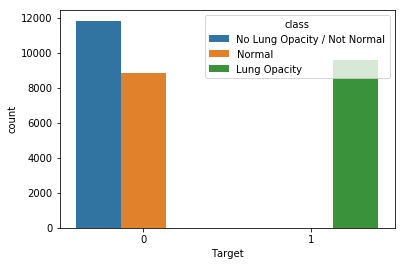

In [0]:
target_class_plot = sns.countplot(data=df, x='Target', hue='class')

## Plotting density of values when Target = 1

We can observe general distributions of the x, y, width, height, data fields in a `distplot`. We first plot the x-axis value by the data column we're interested in. We specify `true` for kde to fit a gaussian kernel density estimate on top of the existing data. We specify `50` bins to spread our data over. We specify `color` for plot colorization. We also specify position in the subplot 2x2 grid by `ax=ax[0,1]`

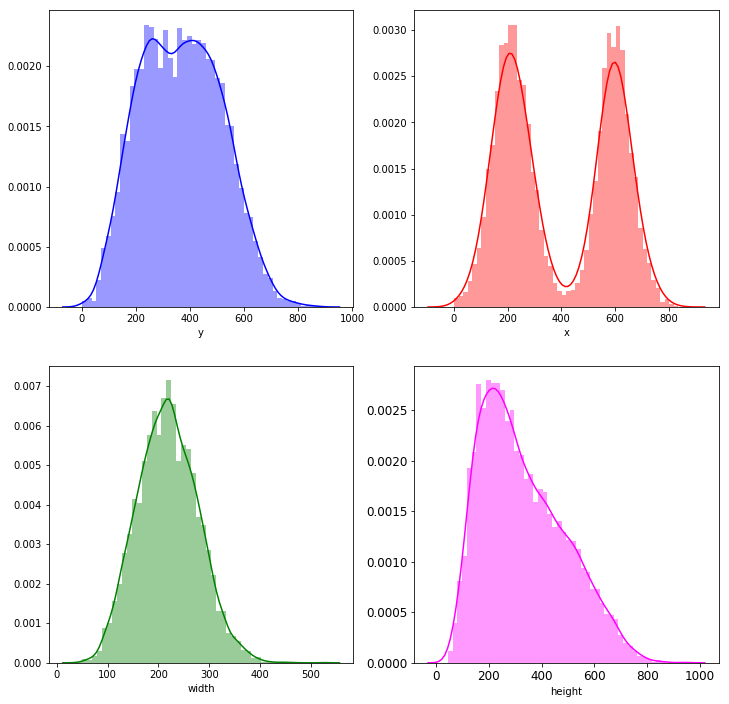

In [0]:
target1_df = df[df['Target']==1]

fig, ax = plt.subplots(2,2, figsize=(12,12))
sns.distplot(target1_df['x'],     kde=True, bins=50, color="red",     ax=ax[0,1])
sns.distplot(target1_df['y'],     kde=True, bins=50, color="blue",    ax=ax[0,0])
sns.distplot(target1_df['width'], kde=True, bins=50, color="green",   ax=ax[1,0])
sns.distplot(target1_df['height'],kde=True, bins=50, color="magenta", ax=ax[1,1])
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

## Plotting midpoints

The midpoint of each window is $x_c = x + width/2$ and $y_c = y + height/2$

We can calculate these new columns and add them to our dataframe and then create a scatter plot of their values.

### Q11

In [0]:
# For rows where there is bounding box (lung opacity), add columns named 'xc' and 'yc'
# representing the midpoint of the box, so we can graph them later.

#### Q11 Answer

In [0]:
target1_df['xc'] = target1_df['x'] + target1_df['width']/2
target1_df['yc'] = target1_df['y'] + target1_df['height']/2
target1_df.head()

patientId      x  ...     xc     yc
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  ...  370.5  341.5
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  ...  690.0  378.5
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  ...  403.0  629.0
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  ...  776.0  643.5
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  ...  335.0  389.5

[5 rows x 10 columns]

### Create a scatter plot of these midpoints

We will use the built in plotting functionality provided by pandas (via matplotlib) to create a scatter plot associated with this new data.  

We can access a set of built-in plot function under our dataframe from the namespace `df.plot` including a scatter plot with `df.plot.scatter`.

We specify the x-center label `xc` and the y-center label `yc`. We specify the range of values for the x and y axis via xlim and ylim respectively. We specify a blending value of 0.5 (0 transparent - 1 opaque). We also specify a point [marker ](https://matplotlib.org/api/markers_api.html#module-matplotlib.markers) `'.'` along with the color.

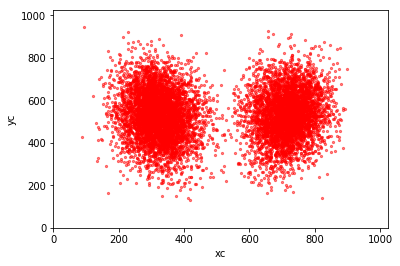

In [0]:
scatter_plot = target1_df.plot.scatter(x='xc', y='yc', xlim=(0,1024), ylim=(0, 1024), alpha=0.5, marker='.', color='red')


## Exploring DICOM data

Let's look at the DICOM data in the training set located in subdirectory `train/`.

We've only loaded a sample of the images, so let's browse the directory to see which files are present.



```os.listdir() ``` is a useful function that takes in a string and gives back a python list of the contents of the directory associated with that string.



### Q12

In [0]:
# How can we get a list of our training images?
# Can we count the number of training images that we have?

#### Q12 Answer


In [0]:
image_file_names = os.listdir('train/')
print(image_file_names[0:5]) # print first 5 file names
print(len(image_file_names))

['23aa5306-99a9-4a8d-a5fc-dfbedf197aca.dcm', '08307845-ccbd-4616-b8e9-58532a766dbe.dcm', '64be85d9-4e40-46d4-bd62-802f2304db21.dcm', '64c717c5-62f8-4434-b967-350679a2d4b9.dcm', '5557ef6d-f13c-401a-9e2d-4d4800b3733f.dcm']
300


Let's convert this python list into a 1 column pandas dataframe.

Then we add a second column based on truncating the last 4 characters (`.dcm`) off each string to get the `patientId` corresponding to each image.


In [0]:
images_df = pd.DataFrame(image_file_names, columns=['file_name'])
images_df['patientId'] = images_df['file_name'].str[:-4] # add a with patientId column taken from file name
images_df

file_name                             patientId
0    23aa5306-99a9-4a8d-a5fc-dfbedf197aca.dcm  23aa5306-99a9-4a8d-a5fc-dfbedf197aca
1    08307845-ccbd-4616-b8e9-58532a766dbe.dcm  08307845-ccbd-4616-b8e9-58532a766dbe
2    64be85d9-4e40-46d4-bd62-802f2304db21.dcm  64be85d9-4e40-46d4-bd62-802f2304db21
3    64c717c5-62f8-4434-b967-350679a2d4b9.dcm  64c717c5-62f8-4434-b967-350679a2d4b9
4    5557ef6d-f13c-401a-9e2d-4d4800b3733f.dcm  5557ef6d-f13c-401a-9e2d-4d4800b3733f
5    97052467-8b50-4fef-a6a7-8d52005acc8f.dcm  97052467-8b50-4fef-a6a7-8d52005acc8f
6    b134c7f3-2f65-4734-93b0-12c482e2b016.dcm  b134c7f3-2f65-4734-93b0-12c482e2b016
7    a296a62a-3e82-4766-b9b6-c27d29a07ab1.dcm  a296a62a-3e82-4766-b9b6-c27d29a07ab1
8    40caa346-8524-4331-9559-1676b16700de.dcm  40caa346-8524-4331-9559-1676b16700de
9    c7270c8d-5bf1-4a6f-83f7-624e0933ed04.dcm  c7270c8d-5bf1-4a6f-83f7-624e0933ed04
10   8c506c25-8bc7-43c7-ba57-62e18116d087.dcm  8c506c25-8bc7-43c7-ba57-62e18116d087
11   fb3c2065-8458-481d-b45c-9e1887409ecb.dcm  fb3c2065-8458-481d-b45c-9e1887409ecb
12   f9b9749d-3509-4678-bffa-e2c60a3f8384.dcm  f9b9749d-3509-4678-bffa-e2c60a3f8384
13   e8ec00ab-611c-4f24-b669-0ae54343a946.dcm  e8ec00ab-611c-4f24-b669-0ae54343a946
14   82752512-2ae2-4445-89f2-46a3d38c3a0d.dcm  82752512-2ae2-4445-89f2-46a3d38c3a0d
15   a5df1553-7c85-46e6-9e0b-870d67d23eb7.dcm  a5df1553-7c85-46e6-9e0b-870d67d23eb7
16   b6744d49-d49b-47c1-b006-0a1256e83452.dcm  b6744d49-d49b-47c1-b006-0a1256e83452
17   aca5cb44-9cfc-420b-a0c4-19f9ef692afb.dcm  aca5cb44-9cfc-420b-a0c4-19f9ef692afb
18   4d23b791-1166-45f1-bf30-8188c75ad5b7.dcm  4d23b791-1166-45f1-bf30-8188c75ad5b7
19   518f3f6f-32d8-4c5a-916a-e9f3670e7210.dcm  518f3f6f-32d8-4c5a-916a-e9f3670e7210
20   5ad76e11-782e-46eb-9eaa-5ce2403c5a89.dcm  5ad76e11-782e-46eb-9eaa-5ce2403c5a89
21   e63c36fd-cbdd-4eab-8e6f-e38b89a0d474.dcm  e63c36fd-cbdd-4eab-8e6f-e38b89a0d474
22   3b57df96-2208-4717-9d32-0d54ebbee4fa.dcm  3b57df96-2208-4717-9d32-0d54ebbee4fa
23   1ed9d674-2a7d-40d9-b40d-e754fc49938e.dcm  1ed9d674-2a7d-40d9-b40d-e754fc49938e
24   e70b90c8-6afe-4da2-936a-c72ccdc371bd.dcm  e70b90c8-6afe-4da2-936a-c72ccdc371bd
25   9a609592-f47b-4c77-ad7b-be4f8833aa1d.dcm  9a609592-f47b-4c77-ad7b-be4f8833aa1d
26   b5afc73c-35b4-4591-a909-919fa968ee06.dcm  b5afc73c-35b4-4591-a909-919fa968ee06
27   f4d869f3-4dc0-4da7-8886-80731365e3f2.dcm  f4d869f3-4dc0-4da7-8886-80731365e3f2
28   82a2e069-1e54-45f5-9c96-49cd1d31f661.dcm  82a2e069-1e54-45f5-9c96-49cd1d31f661
29   24a37f78-cea1-42eb-94a7-b2c51c0f0915.dcm  24a37f78-cea1-42eb-94a7-b2c51c0f0915
..                                        ...                                   ...
270  67c56270-819d-4c3a-8688-5caa6208225d.dcm  67c56270-819d-4c3a-8688-5caa6208225d
271  5dd3e492-247b-49cf-92de-217695dbcf9a.dcm  5dd3e492-247b-49cf-92de-217695dbcf9a
272  5e608de0-7c4b-4e08-8e20-e03c4e840f3b.dcm  5e608de0-7c4b-4e08-8e20-e03c4e840f3b
273  43e9313d-47be-4c69-8b6f-655d6404d7f0.dcm  43e9313d-47be-4c69-8b6f-655d6404d7f0
274  3bb9b9b3-b086-4083-ae6f-d1f86c3eb089.dcm  3bb9b9b3-b086-4083-ae6f-d1f86c3eb089
275  d9763aaf-7377-45e0-a112-2ad0f3bb73ef.dcm  d9763aaf-7377-45e0-a112-2ad0f3bb73ef
276  cad4c8a4-7c91-45ba-86e5-163e81b3075b.dcm  cad4c8a4-7c91-45ba-86e5-163e81b3075b
277  fbff894b-316c-495e-9bba-e6f6228af214.dcm  fbff894b-316c-495e-9bba-e6f6228af214
278  db044ffe-7f5f-47f0-82e9-31ecd93e85ac.dcm  db044ffe-7f5f-47f0-82e9-31ecd93e85ac
279  4b1e649e-9d73-4aaa-b545-8ba3f53ba45e.dcm  4b1e649e-9d73-4aaa-b545-8ba3f53ba45e
280  f62c81d2-f85c-432f-861d-1911b66d9727.dcm  f62c81d2-f85c-432f-861d-1911b66d9727
281  c220d0b1-5b07-4e56-a428-ce977680d131.dcm  c220d0b1-5b07-4e56-a428-ce977680d131
282  b26cc8d8-a11b-4b2f-ad69-41ad37ad5c53.dcm  b26cc8d8-a11b-4b2f-ad69-41ad37ad5c53
283  0a2c130c-c536-4651-836d-95d07e9a89cf.dcm  0a2c130c-c536-4651-836d-95d07e9a89cf
284  c5a8e91a-2d40-4355-91af-73abf5f0fdf1.dcm  c5a8e91a-2d40-4355-91af-73abf5f0fdf1
285  58f28a2b-8fd5-44ce-9ef5-8aa81a957557.dcm  58f28a2b-8fd5-44ce-9ef5-8aa81a957557
286 

In [0]:
merged_df = df.merge(images_df, on='patientId', how='left') # merge with 
merged_df['image_exists'] = ~merged_df['file_name'].isnull() 

# set a boolean column when file_name is not null.  Note `~` which is python's bitwise negation; 
# in pandas bitwise operators will act on each element of a data frame column

merged_df[merged_df['image_exists']] # This selects rows in data frame with images present

patientId  ...  image_exists
68     01e4fd43-4f2c-421f-bd68-c756dceb5742  ...          True
374    072e0dbf-11d7-4c57-8161-10c8e7b2f0bf  ...          True
414    076149ed-e1a7-4424-b283-18161c95e0e2  ...          True
510    08307845-ccbd-4616-b8e9-58532a766dbe  ...          True
601    08ee8fda-45f1-4f46-a5ac-315a8d4dd196  ...          True
766    0a2c130c-c536-4651-836d-95d07e9a89cf  ...          True
787    0a62df77-7459-4acc-9cca-a62c2cec4b0f  ...          True
788    0a62df77-7459-4acc-9cca-a62c2cec4b0f  ...          True
821    0aac426a-b407-4010-b029-34513b6871a6  ...          True
913    0b652c84-50b1-4fa9-8704-94d90827c879  ...          True
1055   0c523b07-6025-4d80-9de3-f435fd92002a  ...          True
1271   12f43927-7592-404e-87c7-4027e114e7ff  ...          True
1425   15f49c72-0702-472d-aff2-4582682392f2  ...          True
1426   15f49c72-0702-472d-aff2-4582682392f2  ...          True
1446   16164b86-ce73-4531-96d0-d6bdd2a96c94  ...          True
1577   1721fcab-c6fb-4688-a1b9-bb3677213085  ...          True
1704   18221e7c-d8f0-4d76-b9b0-eee4aff2a191  ...          True
1731   184ef9f7-6954-4834-817b-9dc9ee976847  ...          True
1747   1871337b-8e0b-4329-93a4-b0d9afc5c814  ...          True
1845   1944c064-d08d-4173-9c7a-a777dcf5262c  ...          True
1878   199ad34d-2478-4948-9f8b-91889c0a4c01  ...          True
2006   2139214a-4a50-4144-9c2d-eb4c929e1e7e  ...          True
2007   2139214a-4a50-4144-9c2d-eb4c929e1e7e  ...          True
2057   23aa5306-99a9-4a8d-a5fc-dfbedf197aca  ...          True
2084   24e11e90-9a36-4ee9-8e27-6b58ba9ecab1  ...          True
2199   2b0fe1f0-e5e8-41b1-8d57-270cc19c5961  ...          True
2559   32a5977f-f8ab-41c9-9b51-5387248e4675  ...          True
2560   32a5977f-f8ab-41c9-9b51-5387248e4675  ...          True
2563   32a837c1-cd10-431d-9dfe-a4f9c1acf53b  ...          True
2595   32d840e8-6bee-4e0b-b942-f18304166ca9  ...          True
...                                     ...  ...           ...
27830  f6e19d24-ce31-4546-8804-b704fff14a45  ...          True
27835  f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  ...          True
27836  f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  ...          True
27854  f722bf9f-827a-40c4-900d-ffeec2a630e6  ...          True
27884  f758a20a-506d-4e4e-97d7-54043148fb59  ...          True
27937  f7b3faca-1b1d-4428-9dc2-086106c871bf  ...          True
27980  f828ad6a-96e3-465b-b189-b0968a34e4a8  ...          True
28194  f9b9749d-3509-4678-bffa-e2c60a3f8384  ...          True
28360  fb0eb436-4668-46fe-8a94-9f06164271f8  ...          True
28377  fb3c2065-8458-481d-b45c-9e1887409ecb  ...          True
28399  fb679675-c42d-4c9f-9006-456eaa860e1d  ...          True
28434  fbb96812-25b1-4354-85bc-9fdb50740c2d  ...          True
28482  fbff894b-316c-495e-9bba-e6f6228af214  ...          True
28703  fde168d7-af3d-4213-9fb5-e0ae8b09c786  ...          True
28772  fe719935-89b2-4f23-b8ed-d56800297a93  ...          True
28775  fe765ddd-3cee-49ef-8cec-d33accd7a5e5  ...          True
29237  0f4c38f3-854f-4f74-9051-59c801a6c859  ...          True
29301  10f2cb81-ad90-4857-a2f7-18e7d8f66907  ...          True
29302  10f2cb81-ad90-4857-a2f7-18e7d8f66907  ...          True
29612  1ed9d674-2a7d-40d9-b40d-e754fc49938e  ...          True
29632  1f70d7ed-d3aa-47d7-acc6-3bc978011e42  ...          True
29662  2055d3d1-e0d1-49a3-a416-2609e5c649bc  ...          True
29759  24a37f78-cea1-42eb-94a7-b2c51c0f0915  ...          True
29786  25957b99-212d-48d2-aef4-ca816f211f0e  ...          True
29787  25957b99-212d-48d2-aef4-ca816f211f0e  ...          True
29896  28eaff00-5fb7-40ee-8206-9d2ff5b081e0  ...          True
30002  2cc72d62-1144-4fe9-a4ab-da083ad11392  ...          True
30003  2cc72d62-1144-4fe9-a4ab-da083ad11392  ...          True
30064  2ee27b62-e1d7-4341-bf2b-9d45dc4068a1  ...          True
30081  2f55650d-f85f-47e7-b6e6-79ad8e3c7c53  ...          True

[344 rows x 10 columns]

The files names are the patients IDs.  In this limited sample for this demonstration, we only have 300 dicom training images loaded.  

If we downloaded the full dataset we would have seen 26684 images in the training set and 3000 images in the test set, but this differs from the 30227 rows in our column.  This will match with the number of unique `patientId` present in our dataframe:

In [0]:
print("Unique patientId in merged_df: ", merged_df['patientId'].nunique()) 


Unique patientId in merged_df:  26684


## Explore Patients With Multiple Rows with `groupby`

Let's see which patients have multiple rows of data (multiple bounding boxes) and their distribution.

First we take our dataframe and `groupby([column_names])` a value, which combined with an aggregating function
(e.g., `count()`, `mean()`, `max()`, `min()`, `sum()`, `median()`) will return the numbers of a column aggregated by that group.  We'll do this to group by `patientId` and see counts of various columns.

In [0]:
grouped_by_patient = merged_df.groupby(['patientId'])
grouped_by_patient.count() # shows how many times is present per value of 'patientId'

x  y  ...  file_name  image_exists
patientId                                   ...                         
0004cfab-14fd-4e49-80ba-63a80b6bddd6  0  0  ...          0             1
000924cf-0f8d-42bd-9158-1af53881a557  0  0  ...          0             1
000db696-cf54-4385-b10b-6b16fbb3f985  2  2  ...          0             2
000fe35a-2649-43d4-b027-e67796d412e0  2  2  ...          0             2
001031d9-f904-4a23-b3e5-2c088acd19c6  2  2  ...          0             2
0010f549-b242-4e94-87a8-57d79de215fc  0  0  ...          0             1
001916b8-3d30-4935-a5d1-8eaddb1646cd  1  1  ...          0             1
0022073f-cec8-42ec-ab5f-bc2314649235  2  2  ...          0             2
0022995a-45eb-4cfa-9a59-cd15f5196c64  0  0  ...          0             1
0025d2de-bd78-4d36-9f72-e15a5e22ca82  0  0  ...          0             1
00293de0-a530-41dc-9621-0b3def01d06d  0  0  ...          0             1
002c591d-df62-4e34-8eda-838c664430a9  0  0  ...          0             1
002cb550-2e31-42f1-a29d-fbc279977e71  2  2  ...          0             2
00313ee0-9eaa-42f4-b0ab-c148ed3241cd  0  0  ...          0             1
00322d4d-1c29-4943-afc9-b6754be640eb  0  0  ...          0             1
003d8fa0-6bf1-40ed-b54c-ac657f8495c5  0  0  ...          0             1
00436515-870c-4b36-a041-de91049b9ab4  2  2  ...          0             2
0049f7b2-229b-4a46-91a3-0e321a3ca80a  0  0  ...          0             1
0053ee32-1e03-4dc2-a103-f46ad0448787  0  0  ...          0             1
00569f44-917d-4c86-a842-81832af98c30  0  0  ...          0             1
005f5517-ab76-4b0d-8a26-f808d97171c4  0  0  ...          0             1
0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4  0  0  ...          0             1
006cec2e-6ce2-4549-bffa-eadfcd1e9970  0  0  ...          0             1
006e75c8-1fd9-4a5a-99e7-285addebed55  0  0  ...          0             1
00704310-78a8-4b38-8475-49f4573b2dbb  2  2  ...          0             2
0087bd3a-55a7-4045-b111-b018fa52d361  2  2  ...          0             2
0088be53-27f2-4c30-882b-a73a3a5c8c71  0  0  ...          0             1
008b69b2-446a-43dd-9ba2-9ccff8f3da41  0  0  ...          0             1
008c19e8-a820-403a-930a-bc74a4053664  0  0  ...          0             1
0092d9c5-26b6-4e66-b196-49b2224ab8d1  0  0  ...          0             1
...                                  .. ..  ...        ...           ...
ffc01e64-ba14-4620-8016-235fc1609767  0  0  ...          0             1
ffc3fc59-f046-48b8-b7ad-3a9e07362d0c  0  0  ...          0             1
ffc9e552-ca53-43a8-a156-b0f97f0d40f3  0  0  ...          0             1
ffcc35e8-6fe8-42df-9605-9fedf57240d1  0  0  ...          0             1
ffcfe8c1-5641-4dc3-910c-573e3227f536  0  0  ...          0             1
ffd0c212-bfb6-41e3-b17b-b927b99d1730  0  0  ...          0             1
ffd2bc74-f9d6-49fb-84d7-de060ee22583  0  0  ...          0             1
ffd56560-6754-4a20-83c6-06ad5c4b30ab  0  0  ...          0             1
ffd670a5-b6dc-4f54-928a-69b7a04662eb  0  0  ...          0             1
ffd787b6-59ca-48cb-bd15-bcedd52cf37c  2  2  ...          0             2
ffdc771e-1f1a-47f7-b732-3e06e48c24e8  0  0  ...          0             1
ffdc8a6a-f513-4a04-9c1d-24840a779220  0  0  ...          0             1
ffdc957e-6239-427d-8a54-fdf8ced3a356  0  0  ...          0             1
ffde3879-241c-4b03-9d91-625cae6b49e8  0  0  ...          0             1
ffde3e7e-849c-4077-bfd0-4e4498ee8817  0  0  ...          0             1
ffe16061-b19f-4333-8a03-b41aab42b47d  0  0  ...          0             1
ffe4707d-517c-4ed0-8a9f-3ad149748991  0  0  ...          0             1
ffe9a1c4-634d-408f-9b0f-8098ffb78a4e  0  0  ...          0             1
ffe9ab5c-9d39-4235-9ade-d725dcad6b76  0  0  ...          0             1
ffeab8ae-f339-40d6-96f1-f1f8c97d2cb1  0  0  ...          0             1
ffee0360-20cf-4d4a-9af5-e5c9b493c73b  0  0  ...          0             1
fff0b503-72a5-446a-843d-f3d152e39053  1  1  ...          0             1
fff1cc9c-3895-43be-84e1

We only care about the number of rows present, so we can select the column `patientId` out of our patient_group like:

`grouped_by_patient['patientId'].count()`

This returns a pandas Series, though we'd rather work with DataFrames so we convert it to a frame with `series.to_frame('NumRows')` which creates a DataFrame with the values of the series in a column named `'NumRows'` in our example.

However, this continues to use `patientId` as the index (which we had been aggregating on), but we want to stop indexing on `patientId` but pull that column into our dataframe as a column, which we can do with  `.reset_index()`

In [0]:
#We care only about number of rows present, which would be:
# grouped_by_patient['patientId'].count()
# Note this is a pandas Series, which we use t
num_rows_df = grouped_by_patient['patientId'].count().to_frame('NumRows').reset_index()
num_rows_df

patientId  NumRows
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6        1
1      000924cf-0f8d-42bd-9158-1af53881a557        1
2      000db696-cf54-4385-b10b-6b16fbb3f985        2
3      000fe35a-2649-43d4-b027-e67796d412e0        2
4      001031d9-f904-4a23-b3e5-2c088acd19c6        2
5      0010f549-b242-4e94-87a8-57d79de215fc        1
6      001916b8-3d30-4935-a5d1-8eaddb1646cd        1
7      0022073f-cec8-42ec-ab5f-bc2314649235        2
8      0022995a-45eb-4cfa-9a59-cd15f5196c64        1
9      0025d2de-bd78-4d36-9f72-e15a5e22ca82        1
10     00293de0-a530-41dc-9621-0b3def01d06d        1
11     002c591d-df62-4e34-8eda-838c664430a9        1
12     002cb550-2e31-42f1-a29d-fbc279977e71        2
13     00313ee0-9eaa-42f4-b0ab-c148ed3241cd        1
14     00322d4d-1c29-4943-afc9-b6754be640eb        1
15     003d8fa0-6bf1-40ed-b54c-ac657f8495c5        1
16     00436515-870c-4b36-a041-de91049b9ab4        2
17     0049f7b2-229b-4a46-91a3-0e321a3ca80a        1
18     0053ee32-1e03-4dc2-a103-f46ad0448787        1
19     00569f44-917d-4c86-a842-81832af98c30        1
20     005f5517-ab76-4b0d-8a26-f808d97171c4        1
21     0067d70b-0e6d-41ff-a9b8-8edf6d5e25e4        1
22     006cec2e-6ce2-4549-bffa-eadfcd1e9970        1
23     006e75c8-1fd9-4a5a-99e7-285addebed55        1
24     00704310-78a8-4b38-8475-49f4573b2dbb        2
25     0087bd3a-55a7-4045-b111-b018fa52d361        2
26     0088be53-27f2-4c30-882b-a73a3a5c8c71        1
27     008b69b2-446a-43dd-9ba2-9ccff8f3da41        1
28     008c19e8-a820-403a-930a-bc74a4053664        1
29     0092d9c5-26b6-4e66-b196-49b2224ab8d1        1
...                                     ...      ...
26654  ffc01e64-ba14-4620-8016-235fc1609767        1
26655  ffc3fc59-f046-48b8-b7ad-3a9e07362d0c        1
26656  ffc9e552-ca53-43a8-a156-b0f97f0d40f3        1
26657  ffcc35e8-6fe8-42df-9605-9fedf57240d1        1
26658  ffcfe8c1-5641-4dc3-910c-573e3227f536        1
26659  ffd0c212-bfb6-41e3-b17b-b927b99d1730        1
26660  ffd2bc74-f9d6-49fb-84d7-de060ee22583        1
26661  ffd56560-6754-4a20-83c6-06ad5c4b30ab        1
26662  ffd670a5-b6dc-4f54-928a-69b7a04662eb        1
26663  ffd787b6-59ca-48cb-bd15-bcedd52cf37c        2
26664  ffdc771e-1f1a-47f7-b732-3e06e48c24e8        1
26665  ffdc8a6a-f513-4a04-9c1d-24840a779220        1
26666  ffdc957e-6239-427d-8a54-fdf8ced3a356        1
26667  ffde3879-241c-4b03-9d91-625cae6b49e8        1
26668  ffde3e7e-849c-4077-bfd0-4e4498ee8817        1
26669  ffe16061-b19f-4333-8a03-b41aab42b47d        1
26670  ffe4707d-517c-4ed0-8a9f-3ad149748991        1
26671  ffe9a1c4-634d-408f-9b0f-8098ffb78a4e        1
26672  ffe9ab5c-9d39-4235-9ade-d725dcad6b76        1
26673  ffeab8ae-f339-40d6-96f1-f1f8c97d2cb1        1
26674  ffee0360-20cf-4d4a-9af5-e5c9b493c73b        1
26675  fff0b503-72a5-446a-843d-f3d152e39053        1
26676  fff1cc9c-3895-43be-84e1-a7aaef21002b        1
26677  fff50447-821b-4b72-ae91-22b0679d6d3e        1
26678  fff7447f-99ce-4102-87f3-9788b2459eb4        1
26679  fffb2395-8edd-4954-8a89-ffe2fd329be3        2
26680  fffba05a-1635-4545-9bbd-57ad4cfe8d27        1
26681  fffc95b5-605b-4226-80ab-62caec682b22        1
26682  fffcff11-d018-4414-971a-a7cefa327795        1
26683  fffec09e-8a4a-48b1-b33e-ab4890ccd136        1

[26684 rows x 2 columns]

In [0]:
# We can then merge this into our dataframe with :

left_df = merged_df.merge(num_rows_df, on='patientId', how='left')
left_df

patientId      x  ...  image_exists  NumRows
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN  ...         False        1
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN  ...         False        1
2      00322d4d-1c29-4943-afc9-b6754be640eb    NaN  ...         False        1
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN  ...         False        1
4      00436515-870c-4b36-a041-de91049b9ab4  264.0  ...         False        2
5      00436515-870c-4b36-a041-de91049b9ab4  562.0  ...         False        2
6      00569f44-917d-4c86-a842-81832af98c30    NaN  ...         False        1
7      006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN  ...         False        1
8      00704310-78a8-4b38-8475-49f4573b2dbb  323.0  ...         False        2
9      00704310-78a8-4b38-8475-49f4573b2dbb  695.0  ...         False        2
10     008c19e8-a820-403a-930a-bc74a4053664    NaN  ...         False        1
11     009482dc-3db5-48d4-8580-5c89c4f01334    NaN  ...         False        1
12     009eb222-eabc-4150-8121-d5a6d06b8ebf    NaN  ...         False        1
13     00a85be6-6eb0-421d-8acf-ff2dc0007e8a    NaN  ...         False        1
14     00aecb01-a116-45a2-956c-08d2fa55433f  288.0  ...         False        2
15     00aecb01-a116-45a2-956c-08d2fa55433f  547.0  ...         False        2
16     00c0b293-48e7-4e16-ac76-9269ba535a62  306.0  ...         False        2
17     00c0b293-48e7-4e16-ac76-9269ba535a62  650.0  ...         False        2
18     00d7c36e-3cdf-4df6-ac03-6c30cdc8e85b    NaN  ...         False        1
19     00f08de1-517e-4652-a04f-d1dc9ee48593  181.0  ...         False        2
20     00f08de1-517e-4652-a04f-d1dc9ee48593  571.0  ...         False        2
21     00f87de5-5fe0-4921-93ea-914d7e683266    NaN  ...         False        1
22     0100515c-5204-4f31-98e0-f35e4b00004a  703.0  ...         False        1
23     01027bc3-dc40-4165-a6c3-d6be2cb7ca34    NaN  ...         False        1
24     010ccb9f-6d46-4380-af11-84f87397a1b8  652.0  ...         False        2
25     010ccb9f-6d46-4380-af11-84f87397a1b8  301.0  ...         False        2
26     011d6f51-b732-4d45-a84d-90477325ef2d    NaN  ...         False        1
27     012a5620-d082-4bb8-9b3b-e72d8938000c  133.0  ...         False        2
28     012a5620-d082-4bb8-9b3b-e72d8938000c  678.0  ...         False        2
29     014b7b58-f641-4477-8bbc-ae6f337745d6    NaN  ...         False        1
...                                     ...    ...  ...           ...      ...
30197  c12aafdd-4d21-4cd3-a2ae-007bce2e2fc0  606.0  ...         False        1
30198  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  131.0  ...         False        2
30199  c1415e26-fddf-4a0c-a7eb-7b9a0d9e9983  497.0  ...         False        2
30200  c145df8e-9631-468d-af7f-5690c11c2c88  601.0  ...         False        2
30201  c145df8e-9631-468d-af7f-5690c11c2c88  173.0  ...         False        2
30202  c14d9ceb-019f-45f6-9299-281b58de57df  578.0  ...         False        2
30203  c14d9ceb-019f-45f6-9299-281b58de57df  239.0  ...         False        2
30204  c1592aae-c80d-4794-ab28-463905558534    NaN  ...         False        1
30205  c1628c47-5ba3-42dd-8df3-7ad3abd57ad0  622.0  ...         False        1
30206  c164b17b-aff8-484f-9d9e-dde2932d8df9    NaN  ...         False        1
30207  c1718678-44af-407f-829a-fc65bc854094    NaN  ...         False        1
30208  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  646.0  ...         False        2
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  295.0  ...         False        2
30210  c196ce23-f37c-4ab3-a9ce-ea8ede90e09c    NaN  ...         False        1
30211  c19b8a3b-ab4e-4a73-8e13-ec0a84b6b6c7    NaN  ...         False        1
30212  c1c3ec5d-20ba-42f7-91f9-48032d97ffc9    NaN  ...         False        1
30213  c1ca4417-83a6-43a7-a9bf-7d9587e7f14f    NaN  ...         False        1
30214  c1cddf32-b957-4753-acaa-472ab1447e86  269.0  ...         False        2
30215  c1cddf32-b957-4753-acaa-472ab1447e86  766.0  ...         False        2
30216

### Q13

In [0]:
# Can we find the maximum # of bounding boxes for our sample of patients?
# Can we easily find the patients for which have the maximum number of bounding boxes?
# Can we obtain their bounding boxes?
# Do we have those dicoms available? If not, which patients have the next most number of bounding boxes, and do we have those dicoms?

#### Q13 Answer

In [0]:
#max_dicom_patients_df = merged_df.groupby(['patientId']).count().to_frame('num_rows')

# Note this is a pandas Series, which we use to_frame
#max_dicom_patients_df = grouped_by_patient.count().to_frame('numRows')
#max_dicom_patients_df

# We care only about number of rows present, which would be:
# grouped_by_patient['patientId'].count()
grouped_by_patient['patientId'].count().describe()

count    26684.000000
mean         1.132776
std          0.356362
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: patientId, dtype: float64

In [0]:
num_rows_df = grouped_by_patient['patientId'].count().to_frame('numRows')
# ie those with maximum number of bounding boxes
max_num_patient_count_df = num_rows_df[num_rows_df.numRows == 4]

In [0]:
right_df = merged_df.merge(max_num_patient_count_df, on='patientId', how='right')
right_df[right_df.image_exists]

Empty DataFrame
Columns: [patientId, x, y, width, height, Target, area, class, file_name, image_exists, numRows]
Index: []

Since we do not currently have the dicoms associated with the most bounding boxes (4) , lets see if we can find patients with 3 bounding boxes

In [0]:
max_num_patient_count_df = num_rows_df[num_rows_df.numRows == 3]
right_df = merged_df.merge(max_num_patient_count_df, on='patientId', how='right')
right_df[right_df.image_exists]

patientId      x  ...  image_exists  numRows
276  e17e53a5-916f-40c8-9c9c-dcc01031aa46  314.0  ...          True        3
277  e17e53a5-916f-40c8-9c9c-dcc01031aa46  241.0  ...          True        3
278  e17e53a5-916f-40c8-9c9c-dcc01031aa46  677.0  ...          True        3

[3 rows x 11 columns]

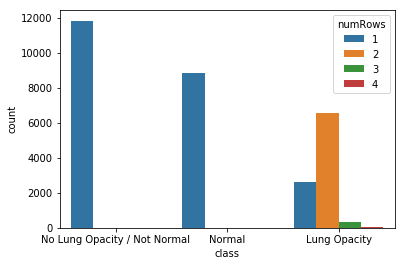

In [0]:
count_plot2 = sns.countplot(x='class', hue='numRows',data=left_df)

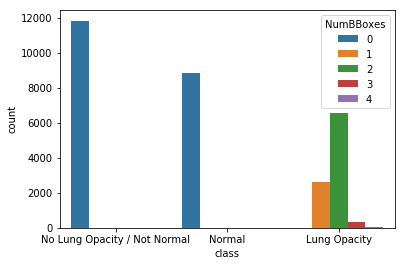

In [0]:
#We could repeat this analysis using counts of non-null 'x' column:
#Is this the same?
num_bboxes_df = df.groupby('patientId')['x'].count().to_frame('NumBBoxes').reset_index()
df2 = df.merge(num_bboxes_df, on='patientId', how='left')
count_plot3 = sns.countplot(x='class', hue='NumBBoxes', data=df2)

In [0]:
# done to not mess up the following code
df = left_df

patientId       03a9498c-549d-4e7d-800b-e74797f7f625
x                                                195
y                                                511
width                                            218
height                                           271
Target                                             1
area                                           59078
class                                   Lung Opacity
file_name                                        NaN
image_exists                                   False
numRows                                            3
Name: 0, dtype: object

## Reading DICOM Meta Data

Pick a patient ID from our populated list

We do this by first looking at data frame of images that exist: `df[df['image_exists']]`, create a new dataframe that samples five randomly with `.sample(5)`. 

We then use integer-based indexing with `.iloc` indexer, and take out the zeroth data value with `.iloc[0]`.
From this returned row we look at the `file_name` attribute.

In [0]:
sample_with_images = df[df['image_exists']].sample(6)
dicom_file_name = sample_with_images.iloc[0]['file_name']
dicom_file_name

'2139214a-4a50-4144-9c2d-eb4c929e1e7e.dcm'

We then open the file, get the `patient_id`

In [0]:
dicom_full_path = os.path.join(ROOT_PATH, 'train', dicom_file_name)
patient_id = dicom_file_name[:-4]
dicom_full_path, patient_id

('/content/pneumonia/train/2139214a-4a50-4144-9c2d-eb4c929e1e7e.dcm',
 '2139214a-4a50-4144-9c2d-eb4c929e1e7e')

Open the dicom file using `pydicom` module

In [0]:
dicom_data = dcm.read_file(dicom_full_path)
dicom_data

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.14718.1517874381.471598
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '2139214a-4a50-4144-9c2d-eb4c929e1e7e'
(0010, 0020) Patient ID                          LO: '2139214a-4a50-4144-9c2d-eb4c929e1e7e'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient'

We can observe that we do have available some useful information in the DICOM metadata with predictive value, for example:

* Patient sex;
* Patient age;
* Modality;
* Body part examined;
* View position;
* Rows & Columns;
* Pixel Spacing.

Let's sample few images having the **Target = 1**.

## Plot DICOM images with Target = 1



In [0]:
def plot_six_dicom_images(df):
    img_data = list(df.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        ax[i//3, i%3].imshow(dcmdata.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'], 
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()
    


Create a sample of six images with `Target == 1`.  We can either name a new dataframe based on the image exists or use bitwise operators between columns when selecting rows of our dataframe.

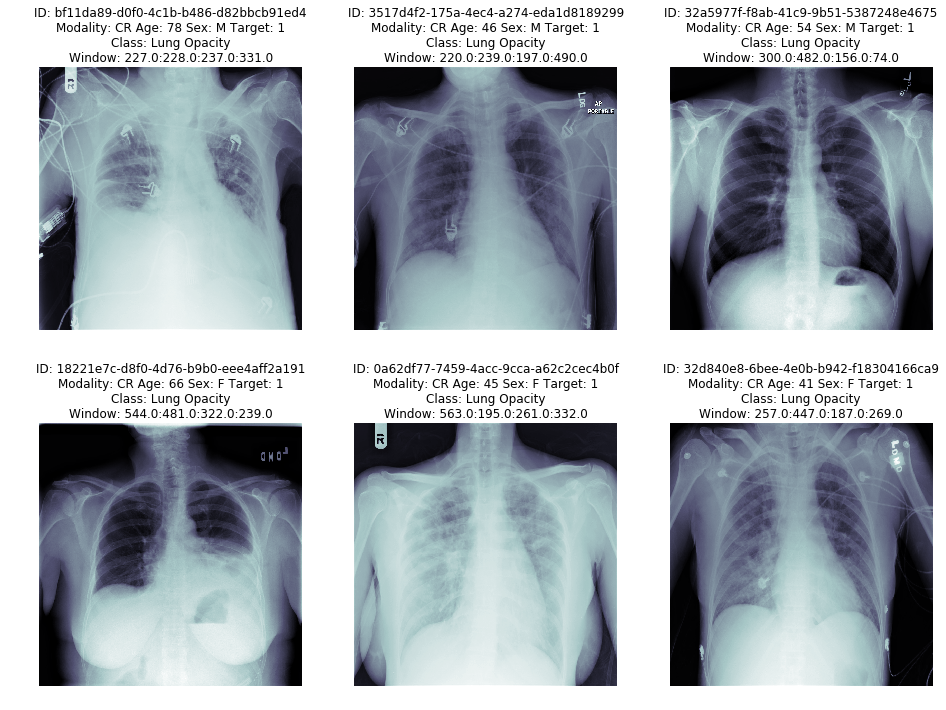

In [0]:
images_present_df = df[df['image_exists']]
target1_sample = images_present_df[images_present_df['Target']==1].sample(6)

# alternatively if you didn't save data frame only containing present images
# you can use bitwise & operator on two boolean columns to select rows where Target is 1 and image_exists is 1

target1_sample = df[df['image_exists'] & (df['Target']==1)].sample(6)

plot_six_dicom_images(target1_sample)

We would like to represent the images with the overlay boxes superposed. For this, we will need first to parse the whole dataset with Target = 1 and gather all coordinates of the windows showing a Lung Opacity on the same image.


In [0]:
from matplotlib.patches import Rectangle

def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i,data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        ax[i//3, i%3].imshow(dcmdata.pixel_array, cmap=plt.cm.bone) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = merged_df[merged_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="yellow",alpha = 0.1))   
    plt.show()


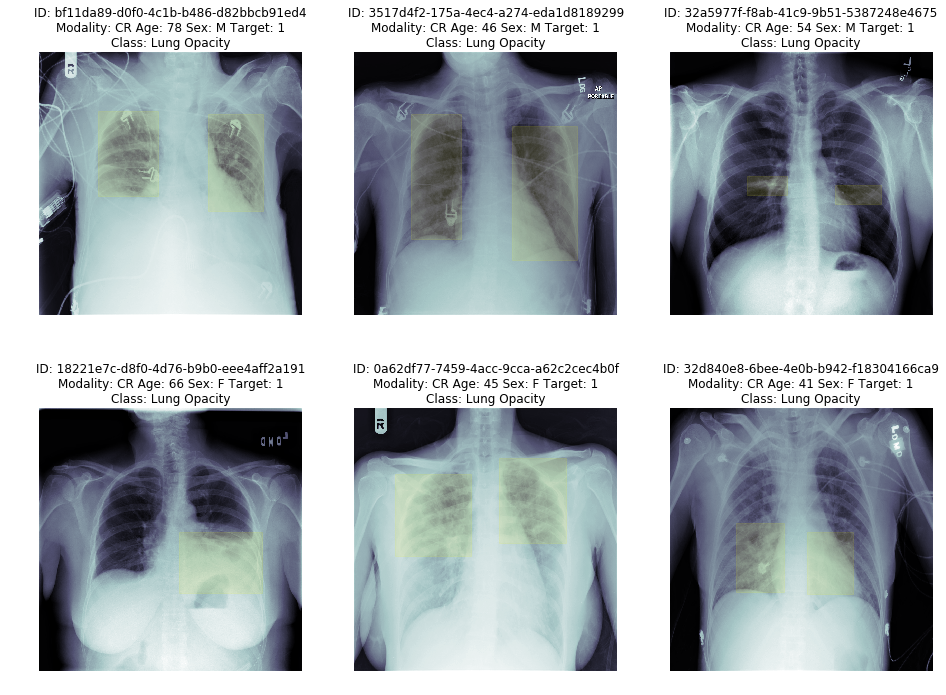

In [0]:
show_dicom_images_with_boxes(target1_sample)

### Q14

In [0]:
# Can you plot the patient case where there are 3 bounding boxes?

#### Q14 Answer

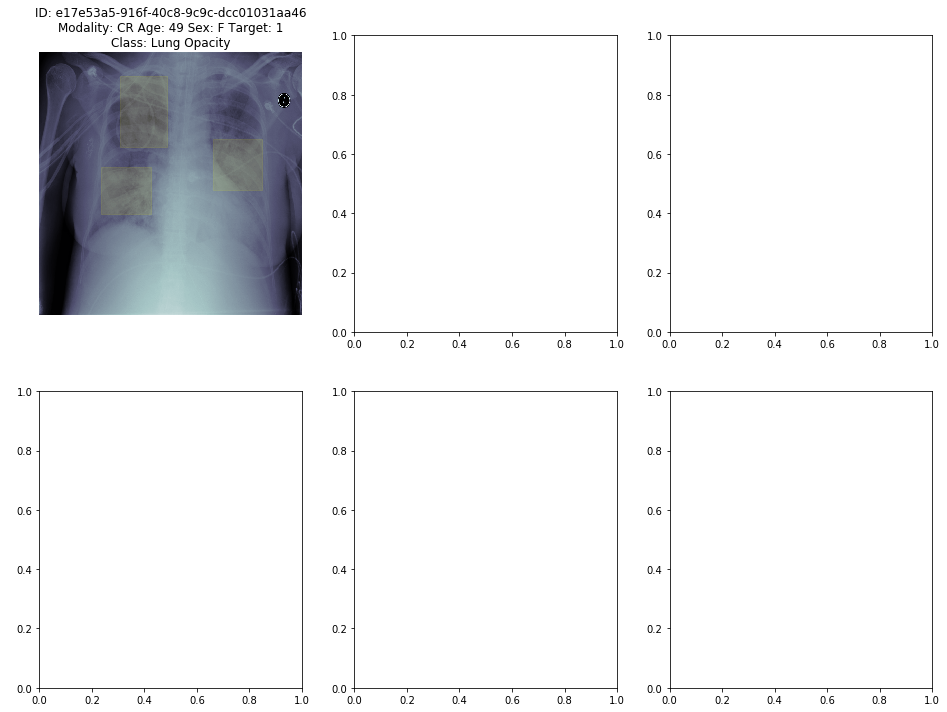

In [0]:
show_dicom_images_with_boxes(right_df[right_df.image_exists].sample(1))


For some of the images with **Target=1**, we might see multiple areas (boxes/rectangles) with Lung Opacity.

Let's sample few images having the **Target = 0**.

## Plot DICOM images with Target = 0


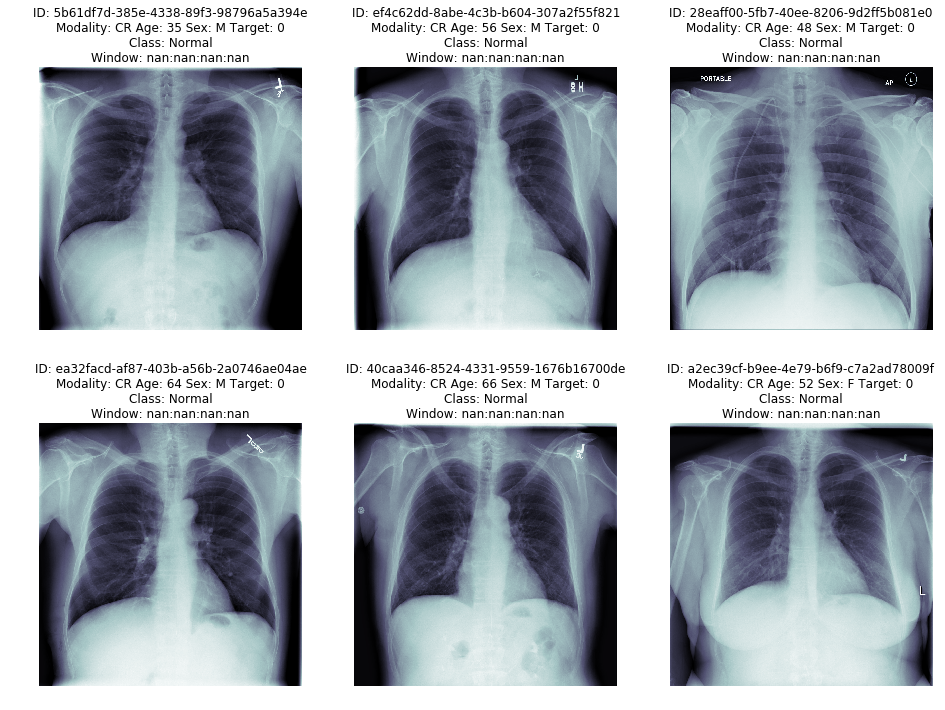

In [0]:
## Normal images
target0_sample_normal = images_present_df[images_present_df['class']=='Normal'].drop_duplicates(subset='patientId').sample(6)
plot_six_dicom_images(target0_sample_normal)

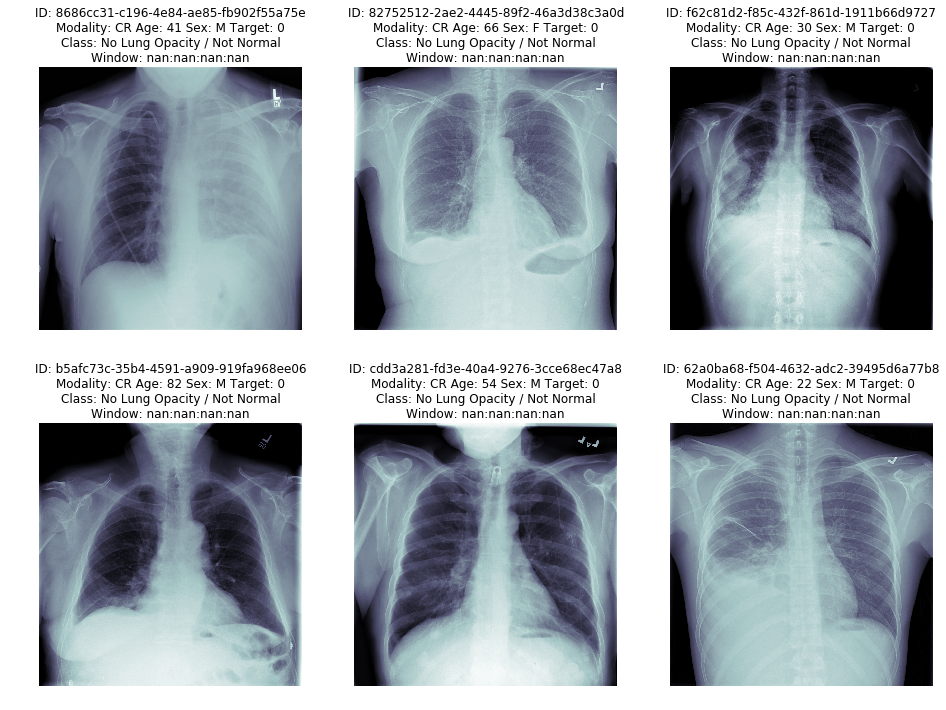

In [0]:
## No Lung Opacity
target0_sample_abnormal = images_present_df[images_present_df['class']=='No Lung Opacity / Not Normal'].drop_duplicates(subset='patientId').sample(6)
plot_six_dicom_images(target0_sample_abnormal)

#Add meta information from DICOM files

##Train data

We will read the DICOM meta data from the dicome files and add it to the train dataset.

In [0]:
dcmfields = ['PatientID', 'Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_image_dir(data_path):
    image_names = os.listdir(data_path)
    image_meta_data = []
    for i, img_name in enumerate(image_names):
        imagePath = os.path.join(data_path, img_name)
        dcmdata = dcm.dcmread(imagePath, stop_before_pixels=True)
        meta_data_row = [dcmdata.get(field) for field in dcmfields]
        image_meta_data.append(meta_data_row)
    return pd.DataFrame(image_meta_data, columns=dcmfields)

In [0]:
dcm_metadata_df = process_dicom_image_dir(os.path.join(ROOT_PATH, 'train'))
dcm_metadata_df = dcm_metadata_df.rename(columns={'PatientID':'patientId'})
dcm_metadata_df

patientId  ...                                PixelSpacing
0    23aa5306-99a9-4a8d-a5fc-dfbedf197aca  ...                              [0.139, 0.139]
1    08307845-ccbd-4616-b8e9-58532a766dbe  ...                              [0.168, 0.168]
2    64be85d9-4e40-46d4-bd62-802f2304db21  ...                              [0.168, 0.168]
3    64c717c5-62f8-4434-b967-350679a2d4b9  ...                              [0.139, 0.139]
4    5557ef6d-f13c-401a-9e2d-4d4800b3733f  ...                              [0.139, 0.139]
5    97052467-8b50-4fef-a6a7-8d52005acc8f  ...  [0.19431099999999998, 0.19431099999999998]
6    b134c7f3-2f65-4734-93b0-12c482e2b016  ...                              [0.171, 0.171]
7    a296a62a-3e82-4766-b9b6-c27d29a07ab1  ...  [0.14300000000000002, 0.14300000000000002]
8    40caa346-8524-4331-9559-1676b16700de  ...  [0.14300000000000002, 0.14300000000000002]
9    c7270c8d-5bf1-4a6f-83f7-624e0933ed04  ...                              [0.139, 0.139]
10   8c506c25-8bc7-43c7-ba57-62e18116d087  ...                              [0.168, 0.168]
11   fb3c2065-8458-481d-b45c-9e1887409ecb  ...                              [0.139, 0.139]
12   f9b9749d-3509-4678-bffa-e2c60a3f8384  ...                              [0.139, 0.139]
13   e8ec00ab-611c-4f24-b669-0ae54343a946  ...                              [0.168, 0.168]
14   82752512-2ae2-4445-89f2-46a3d38c3a0d  ...  [0.19431099999999998, 0.19431099999999998]
15   a5df1553-7c85-46e6-9e0b-870d67d23eb7  ...                              [0.168, 0.168]
16   b6744d49-d49b-47c1-b006-0a1256e83452  ...  [0.14300000000000002, 0.14300000000000002]
17   aca5cb44-9cfc-420b-a0c4-19f9ef692afb  ...                              [0.168, 0.168]
18   4d23b791-1166-45f1-bf30-8188c75ad5b7  ...                              [0.168, 0.168]
19   518f3f6f-32d8-4c5a-916a-e9f3670e7210  ...                              [0.168, 0.168]
20   5ad76e11-782e-46eb-9eaa-5ce2403c5a89  ...  [0.14300000000000002, 0.14300000000000002]
21   e63c36fd-cbdd-4eab-8e6f-e38b89a0d474  ...  [0.14300000000000002, 0.14300000000000002]
22   3b57df96-2208-4717-9d32-0d54ebbee4fa  ...                              [0.168, 0.168]
23   1ed9d674-2a7d-40d9-b40d-e754fc49938e  ...  [0.19431400000000001, 0.19431400000000001]
24   e70b90c8-6afe-4da2-936a-c72ccdc371bd  ...  [0.14300000000000002, 0.14300000000000002]
25   9a609592-f47b-4c77-ad7b-be4f8833aa1d  ...  [0.14300000000000002, 0.14300000000000002]
26   b5afc73c-35b4-4591-a909-919fa968ee06  ...  [0.14300000000000002, 0.14300000000000002]
27   f4d869f3-4dc0-4da7-8886-80731365e3f2  ...                              [0.168, 0.168]
28   82a2e069-1e54-45f5-9c96-49cd1d31f661  ...  [0.14300000000000002, 0.14300000000000002]
29   24a37f78-cea1-42eb-94a7-b2c51c0f0915  ...  [0.14300000000000002, 0.14300000000000002]
..                                    ...  ...                                         ...
270  67c56270-819d-4c3a-8688-5caa6208225d  ...                              [0.139, 0.139]
271  5dd3e492-247b-49cf-92de-217695dbcf9a  ...                              [0.168, 0.168]
272  5e608de0-7c4b-4e08-8e20-e03c4e840f3b  ...                              [0.168, 0.168]
273  43e9313d-47be-4c69-8b6f-655d6404d7f0  ...                              [0.171, 0.171]
274  3bb9b9b3-b086-4083-ae6f-d1f86c3eb089  ...                              [0.171, 0.171]
275  d9763aaf-7377-45e0-a112-2ad0f3bb73ef  ...  [0.14300000000000002, 0.14300000000000002]
276  cad4c8a4-7c91-45ba-86e5-163e81b3075b  ...  [0.14300000000000002, 0.14300000000000002]
277  fbff894b-316c-495e-9bba-e6f6228af214  ...  [0.19431099999999998, 0.19431099999999998]
278  db044ffe-7f5f-47f0-82e9-31ecd93e85ac  ...  [0.14300000000000002, 0.14300000000000002]
279  4b1e649e-9d73-4aaa-b545-8ba3f53ba45e  ...                              [0.139, 0.139]
280  f62c81d2-f85c-432f-861d-1911b66d9727  ...  [0.14300000000000002, 0.14300000000000002]
281  c220d0b1-5b07-4e56-a428-ce977680d131  ...                              [0.139, 0.139]
282  b26cc8d8-a11b-4b2f-ad69

In [0]:
merged_df = df.merge(dcm_metadata_df, on='patientId', how='left')
merged_df[merged_df['image_exists']]

patientId  ...                                PixelSpacing
68     01e4fd43-4f2c-421f-bd68-c756dceb5742  ...  [0.14300000000000002, 0.14300000000000002]
374    072e0dbf-11d7-4c57-8161-10c8e7b2f0bf  ...  [0.14300000000000002, 0.14300000000000002]
414    076149ed-e1a7-4424-b283-18161c95e0e2  ...  [0.14300000000000002, 0.14300000000000002]
510    08307845-ccbd-4616-b8e9-58532a766dbe  ...                              [0.168, 0.168]
601    08ee8fda-45f1-4f46-a5ac-315a8d4dd196  ...                              [0.168, 0.168]
766    0a2c130c-c536-4651-836d-95d07e9a89cf  ...  [0.14300000000000002, 0.14300000000000002]
787    0a62df77-7459-4acc-9cca-a62c2cec4b0f  ...                              [0.168, 0.168]
788    0a62df77-7459-4acc-9cca-a62c2cec4b0f  ...                              [0.168, 0.168]
821    0aac426a-b407-4010-b029-34513b6871a6  ...                              [0.139, 0.139]
913    0b652c84-50b1-4fa9-8704-94d90827c879  ...                              [0.139, 0.139]
1055   0c523b07-6025-4d80-9de3-f435fd92002a  ...  [0.14300000000000002, 0.14300000000000002]
1271   12f43927-7592-404e-87c7-4027e114e7ff  ...  [0.14300000000000002, 0.14300000000000002]
1425   15f49c72-0702-472d-aff2-4582682392f2  ...                              [0.168, 0.168]
1426   15f49c72-0702-472d-aff2-4582682392f2  ...                              [0.168, 0.168]
1446   16164b86-ce73-4531-96d0-d6bdd2a96c94  ...  [0.14300000000000002, 0.14300000000000002]
1577   1721fcab-c6fb-4688-a1b9-bb3677213085  ...  [0.14300000000000002, 0.14300000000000002]
1704   18221e7c-d8f0-4d76-b9b0-eee4aff2a191  ...  [0.14300000000000002, 0.14300000000000002]
1731   184ef9f7-6954-4834-817b-9dc9ee976847  ...  [0.14300000000000002, 0.14300000000000002]
1747   1871337b-8e0b-4329-93a4-b0d9afc5c814  ...                              [0.168, 0.168]
1845   1944c064-d08d-4173-9c7a-a777dcf5262c  ...                              [0.171, 0.171]
1878   199ad34d-2478-4948-9f8b-91889c0a4c01  ...  [0.19431099999999998, 0.19431099999999998]
2006   2139214a-4a50-4144-9c2d-eb4c929e1e7e  ...                              [0.168, 0.168]
2007   2139214a-4a50-4144-9c2d-eb4c929e1e7e  ...                              [0.168, 0.168]
2057   23aa5306-99a9-4a8d-a5fc-dfbedf197aca  ...                              [0.139, 0.139]
2084   24e11e90-9a36-4ee9-8e27-6b58ba9ecab1  ...  [0.14300000000000002, 0.14300000000000002]
2199   2b0fe1f0-e5e8-41b1-8d57-270cc19c5961  ...                              [0.139, 0.139]
2559   32a5977f-f8ab-41c9-9b51-5387248e4675  ...  [0.14300000000000002, 0.14300000000000002]
2560   32a5977f-f8ab-41c9-9b51-5387248e4675  ...  [0.14300000000000002, 0.14300000000000002]
2563   32a837c1-cd10-431d-9dfe-a4f9c1acf53b  ...                              [0.168, 0.168]
2595   32d840e8-6bee-4e0b-b942-f18304166ca9  ...                              [0.168, 0.168]
...                                     ...  ...                                         ...
27830  f6e19d24-ce31-4546-8804-b704fff14a45  ...                              [0.168, 0.168]
27835  f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  ...                              [0.171, 0.171]
27836  f6ea62b5-fb92-45b3-b59b-2f9b6d8b7e7e  ...                              [0.171, 0.171]
27854  f722bf9f-827a-40c4-900d-ffeec2a630e6  ...  [0.19431099999999998, 0.19431099999999998]
27884  f758a20a-506d-4e4e-97d7-54043148fb59  ...  [0.14300000000000002, 0.14300000000000002]
27937  f7b3faca-1b1d-4428-9dc2-086106c871bf  ...                              [0.171, 0.171]
27980  f828ad6a-96e3-465b-b189-b0968a34e4a8  ...  [0.14300000000000002, 0.14300000000000002]
28194  f9b9749d-3509-4678-bffa-e2c60a3f8384  ...                              [0.139, 0.139]
28360  fb0eb436-4668-46fe-8a94-9f06164271f8  ...                              [0.168, 0.168]
28377  fb3c2065-8458-481d-b45c-9e1887409ecb  ...                              [0.139, 0.139]
28399  fb679675-c42d-4c9f-9006-456eaa860e1d  ...                              [0.139, 0.139]
28434  fbb96812-25b1-4354-85bc-9fdb

## We only downloaded a subset of data

Using same function above we can read the metadata of all 26,684 training dicoms and 3000 test dicoms in 30 seconds of processing total.


In [0]:
if use_full:
  import time
  a = time.time()
  dcm_train_metadata_full_df = process_dicom_image_dir('train/')
  dcm_test_metadata_full_df = process_dicom_image_dir('test/')
  b = time.time()
  print(b-a, 'seconds elapsed')
  dcm_train_metadata_full_df.to_csv('extras/dcm_train_metadata_full.csv', index=False)
  dcm_test_metadata_full_df.to_csv('extras/dcm_test_metadata_full.csv', index=False)
else:
  dcm_train_metadata_full_df = pd.read_csv('extras/dcm_train_metadata_full.csv')
  dcm_test_metadata_full_df = pd.read_csv('extras/dcm_test_metadata_full.csv')  

In [0]:
merged_df = df.merge(dcm_train_metadata_full_df, on='patientId', how='left')


## Inspecting the DCM Data Fields

If we look at our full training data's dicom fields we see:

In [0]:
merged_df[['Modality', 'BodyPartExamined', 'PatientSex', 'ViewPosition', 'ConversionType']].describe()

Modality BodyPartExamined PatientSex ViewPosition ConversionType
count     30227            30227      30227        30227          30227
unique        1                1          2            2              1
top          CR            CHEST          M           AP            WSD
freq      30227            30227      17216        15297          30227

We see that **Modality**, **BodyPartExamined** and **ConversionType** all have exactly one value in all their cells (`unique=1`), hence all these images are modality `CR` (Computed Radiograph) that examined body part `CHEST`, with ConversionType WSD (Workstation).

We do have 2 unique values for PatientSex and ViewPosition



In [0]:
merged_df[['PatientAge', 'Rows', 'Columns']].describe()

PatientAge     Rows  Columns
count  30227.000000  30227.0  30227.0
mean      46.797764   1024.0   1024.0
std       16.892940      0.0      0.0
min        1.000000   1024.0   1024.0
25%       34.000000   1024.0   1024.0
50%       49.000000   1024.0   1024.0
75%       59.000000   1024.0   1024.0
max      155.000000   1024.0   1024.0

We also see for the numerical data of **Rows** and **Columns** that all the data is in a fixed shape with 1024 rows and 1024 columns.  These columns were inputed as numerical data, but we can note they are all identical by either noting that the **std** is 0 or that the **min** and **max** are both equal.

Meanwhile there's a wide array of **PatientAge** present including several data points that appear to be incorrect (PatientAge = 155)

## Inspecting View Position

We do observe that the ViewPosition changes between **PA** (posterior/anterior - with the patient facing away from the X-ray source) and AP (anteriorposterior - with the patient facing towards the X-ray source) in our dataset.

AP    7788
PA    1767
Name: ViewPosition, dtype: int64


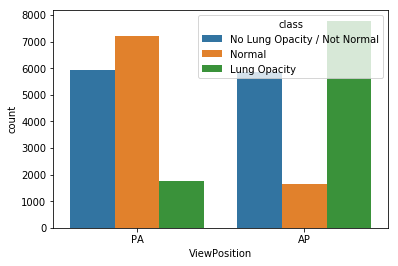

In [0]:
ax=sns.countplot(data=merged_df, x='ViewPosition', hue='class')
print(merged_df[merged_df['Target'] == 1]['ViewPosition'].value_counts())

## Inspecting PatientSex



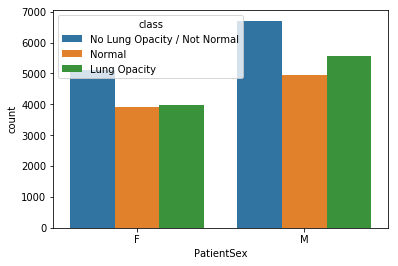

In [0]:
ax=sns.countplot(data=merged_df, x='PatientSex', hue='class')

## Inspecting PatientAge



Incorrect ages (greater than 130): 5


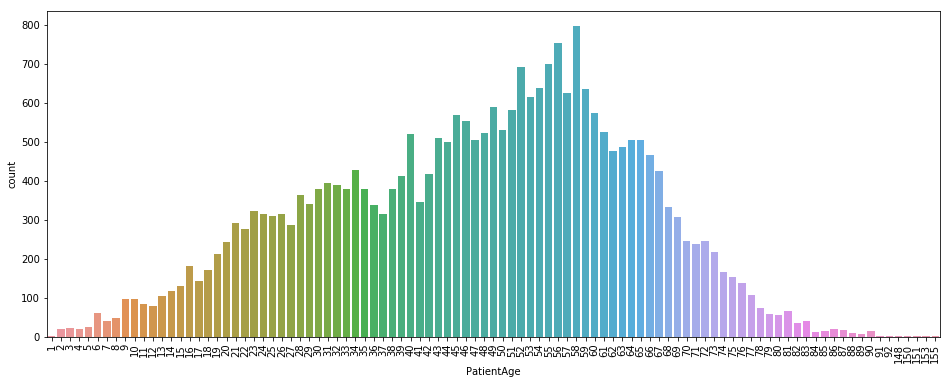

In [0]:
fig = plt.figure(figsize=(16,6))
plt.xticks(rotation=90)
ax=sns.countplot(data=dcm_train_metadata_full_df, x='PatientAge')

print("Incorrect ages (greater than 130):", (dcm_train_metadata_full_df['PatientAge'] > 130).sum())

# Number of Target Cases plot by PatientSex

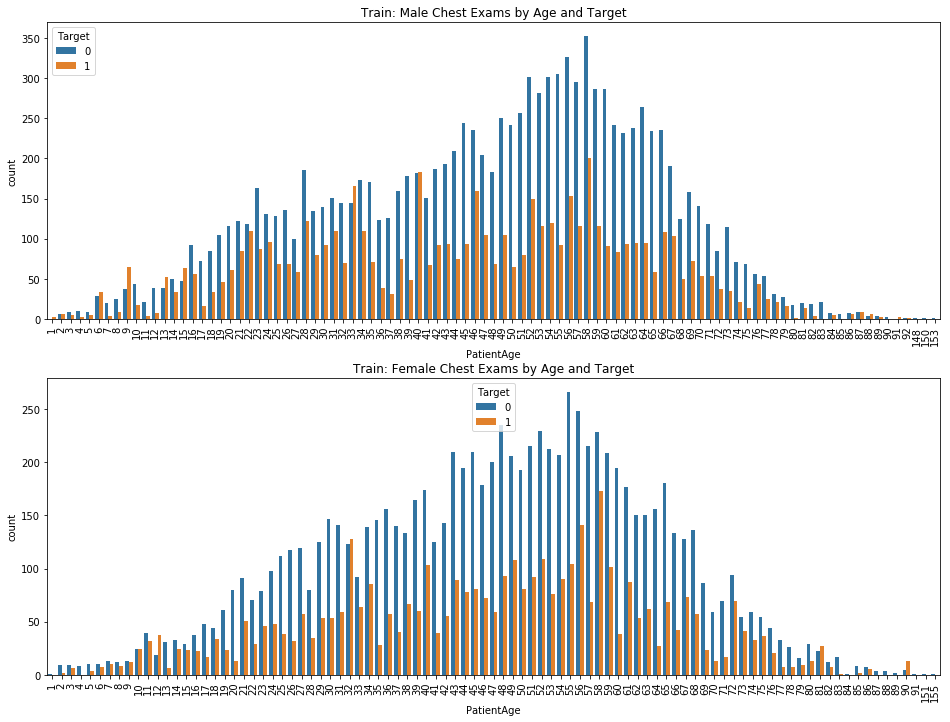

In [0]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(211)
plt.xticks(rotation=90)
ax2 = fig.add_subplot(212)
plt.xticks(rotation=90)
ax1.set_title("Train: Male Chest Exams by Age and Target")
ax1=sns.countplot(x='PatientAge', hue='Target', data=merged_df[merged_df['PatientSex']=='M'], ax=ax1)
ax2.set_title("Train: Female Chest Exams by Age and Target")
ax2=sns.countplot(x='PatientAge', hue='Target', data=merged_df[merged_df['PatientSex']=='F'], ax=ax2)


## Bounding Box Mask

To determine where to look for potential lung opacity, let's create a 1024x1024 box showing summing all the labeled bounding box regions in our training set.

`np.linspace(0, 1023, 1024)` create an numpy array `[0, 1, 2, ..., 1023]` with 1024 values.

`xx, yy = np.meshgrid(arr1, arr2)` creates two 2d-arrays (`xx`, `yy`) of the shape `len(arr1) x len(arr2)`. 

Every row of `xx` is a copy of `arr1` and there are `len(arr2)` copies present.

Every column of `yy` is a copy of `arr2` and there are `len(arr1)` copies present.



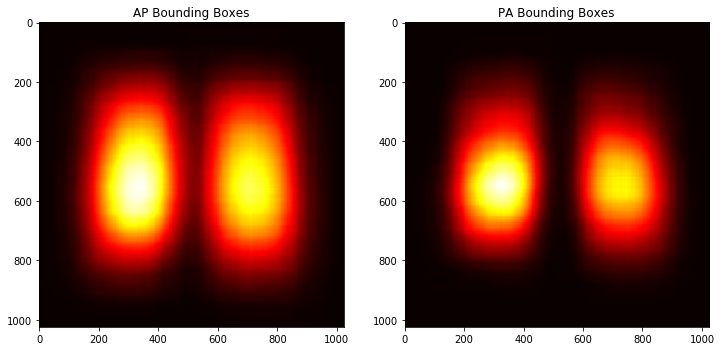

In [0]:
xx, yy = np.meshgrid(np.linspace(0, 1023, 1024),
                     np.linspace(0, 1023, 1024), 
                     indexing='xy')
# xx is a 1024 x 1024 2d array where every row is [0, 1, 2, 3, ... ,1023]
# yy is a 1024 x 1024 2d array where the zeroth row is [0, 0, 0, ... ]
# the next row is [1, 1, 1, ...] ; i-th row is [i, i, i, ]

# in our example xx[i,j] will always be i and `yy[i,j]` will always be j
# so it makes it possible to quickly do vectorized math based on bounding box coordinates.


bboxes = {}
bboxes['AP'] = np.zeros_like(xx)
bboxes['PA'] = np.zeros_like(xx)
## Creates a zero filled array in same shape


for view in ('AP', 'PA'):
  for i, bbox in merged_df[(merged_df['Target']==1) & (merged_df['ViewPosition']==view)].sample(1767).iterrows():
      mask  = (xx >= bbox['x']) & (xx <= (bbox['x'] + bbox['width'] ))
      mask &= (yy >= bbox['y']) & (yy <= (bbox['y'] + bbox['height']))
      bboxes[view] += mask
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.set_title("AP Bounding Boxes")
subfig1 = ax1.imshow(bboxes['AP'], cmap='hot')

ax2.set_title("PA Bounding Boxes")
subfig2 = ax2.imshow(bboxes['PA'], cmap='hot')


## Overlay

We can then overlay this probability map over images from our training set.

In [0]:
def show_dicom_images_with_bbox_dist(data, bboxes):    
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(2,3, figsize=(16,12))
    for i, data_row in enumerate(img_data):
        patientImage = data_row['patientId']+'.dcm'
        imagePath = os.path.join(ROOT_PATH, 'train', patientImage)
        dcmdata = dcm.dcmread(imagePath)
        modality = dcmdata.Modality
        age = dcmdata.PatientAge
        sex = dcmdata.PatientSex
        view = dcmdata.ViewPosition
        img = plt.cm.gray(dcmdata.pixel_array)
        img += 0.25*plt.cm.hot(bboxes[view]/bboxes[view].max())
        img = np.clip(img, 0, 1)

        ax[i//3, i%3].imshow(img) 
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nView: {}, Class: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], view, data_row['class']))
        rows = merged_df[merged_df['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())       
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'], 
                        color="green", fill=False))   
    plt.show()


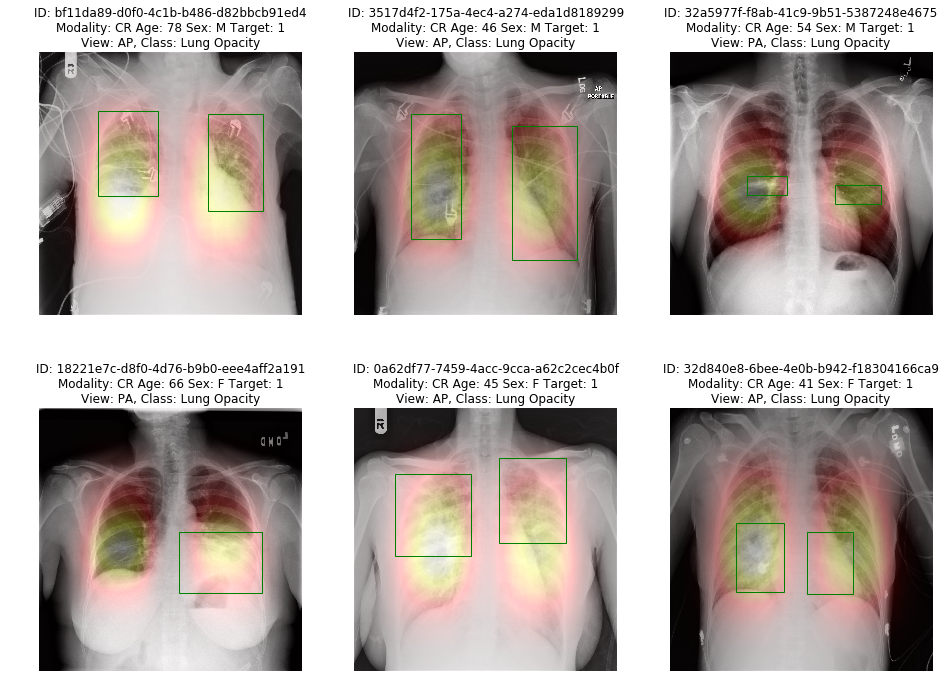

In [0]:
show_dicom_images_with_bbox_dist(target1_sample, bboxes)